In [1]:
import numpy as np
import os, sys, time 
import pandas as pd
import zipfile, tarfile, requests  # TODO: Ensure package requests is installed
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, normalize
from sklearn import metrics
import eif as iso
from sklearn.utils import shuffle
from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM
from sklearn.neighbors import LocalOutlierFactor


from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
np.random.seed(56)
import random

# packages required for proecessing zip files
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

# packages for plots and graphs
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
#import XGBClassifier
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

%matplotlib inline

import requests, zipfile
import warnings
warnings.filterwarnings('ignore')

In [2]:
def getData():
    with ZipFile("elliptic-data-set.zip") as zfile:
        df_node_transactions = pd.read_csv(zfile.open('elliptic_bitcoin_dataset/elliptic_txs_classes.csv'))
        df_edge_payments = pd.read_csv(zfile.open('elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv'))
        df_features = pd.read_csv(zfile.open('elliptic_bitcoin_dataset/elliptic_txs_features.csv'))
    return df_node_transactions,df_edge_payments,df_features

The dataset consists of 203,769 transactions, of which 21% are
labeled as licit, and 2% as illicit, based on the category of the bitcoin
address that created the transaction. The remaining transactions
are unlabeled. Illicit categories include scams, malware, terrorist organizations, and Ponzi schemes. Licit categories include exchanges,
wallet providers, miners, and licit services. Each transaction has 166
features, 94 of which represent information about the transaction
itself. The remaining features were constructed 
using information one-hop backward/forward from the transaction,
such as the minimum, maximum, and standard deviation of each
transaction feature. All features, except for the time-step, are fully
anonymized and standardized with zero mean and unit variance.

In [3]:
df_node_transactions,df_edge_payments,df_features = getData()

## Nodes and Edges. 
There are 203,769 node transactions and
234,355 directed edge payments flows. 

In [4]:
df_node_transactions.head()

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown


In [5]:
df_edge_payments.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


## Features:  
Each node has associated 166 features. The first 94
features represent local information about the transaction – including the time step, number of inputs/outputs, transaction fee, output
volume and aggregated figures such as average BTC received (spent)
by the inputs/outputs and average number of incoming (outgoing)
transactions associated with the inputs/outputs. The remaining 72
features, called aggregated features, are obtained by aggregating
transaction information one-hop backward/forward from the center node - giving the maximum, minimum, standard deviation and
correlation coefficients of the neighbour transactions for the same
information data (number of inputs/outputs, transaction fee, etc.).

In [6]:
df_features.head()

,230425980,1,-0.1714692896288031,-0.18466755143291433,-1.2013688016765636,-0.12196959975910057,-0.04387454791734898,-0.11300200928476244,-0.06158379407303222,-0.16209679981659642,...,-0.5621534802884299,-0.6009988905192808,1.4613303209554889,1.4613689382001922,0.01827940003744589,-0.0874901561101501,-0.13115530389558736,-0.09752359377152515,-0.12061340670311574,-0.11979245961251665
0,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
2,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
3,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
4,230459870,1,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,-0.163577,...,-0.504702,-0.422589,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540


In [7]:
colNames1 = {'0': 'txId', '1': "Time step"}
colNames2 = {str(i+2): "Local_feature_" + str(i+1) for i in range(93)}
colNames3 = {str(j+95): "Aggregate_feature_" + str(j+1) for j in range(72)}
#combine dictionaries
colNames = dict(**colNames1, **colNames2, **colNames3 )

df_features.columns = colNames.values()
df_features.head()

,txId,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
2,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
3,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
4,230459870,1,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,-0.163577,...,-0.504702,-0.422589,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540


In [8]:
print('Shape of classes', df_node_transactions.shape)
print('Shape of edges', df_edge_payments.shape)
print('Shape of features', df_features.shape)

Shape of classes (203769, 2)
Shape of edges (234355, 2)
Shape of features (203768, 167)


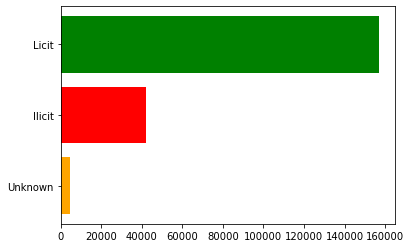

In [9]:
df_node_transactions.loc[df_node_transactions['class'] == 'unknown', 'class'] = '3'
group_class = df_node_transactions.groupby('class').count()
plt.barh(['Unknown', 'Ilicit', 'Licit'], group_class['txId'].values, \
         color=['orange', 'r', 'g'] );

### Number of transactions per Time step

Text(0.5, 1.0, 'Number of transactions by Time step')

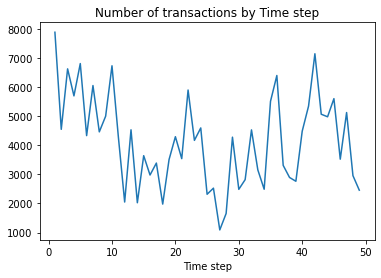

In [10]:
group_feature = df_features.groupby('Time step').count()
group_feature['txId'].plot()
plt.title('Number of transactions by Time step')

In [11]:
print(len(df_node_transactions.txId.unique()))
len(df_features.txId.unique())

203769


203768

In [12]:
# Merge Class and features
df_nodetrans_feature = pd.merge(df_features,df_node_transactions, on='txId',how='left' )

df_nodetrans_feature.head()

,txId,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,...,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72,class
0,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,3
1,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,3
2,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,2
3,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,3
4,230459870,1,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,-0.163577,...,-0.422589,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540,3


In [13]:
nodetrans_feature = df_nodetrans_feature.groupby(['Time step', 'class']).count()
nodetrans_feature = nodetrans_feature['txId'].reset_index().\
rename(columns={'txId': 'count'})#unstack()
nodetrans_feature.head()

,Time step,class,count
0,1,1,17
1,1,2,2130
2,1,3,5732
3,2,1,18
4,2,2,1099


Text(0.5, 0, 'Time step')

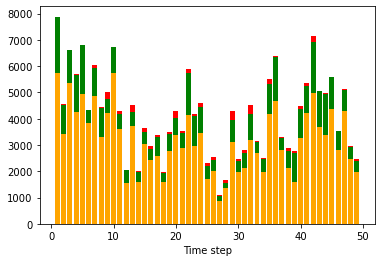

In [14]:
class1 = nodetrans_feature[nodetrans_feature['class'] == '1']
class2 = nodetrans_feature[nodetrans_feature['class'] == '2']
class3 = nodetrans_feature[nodetrans_feature['class'] == '3']

p1 = plt.bar(class3['Time step'], class3['count'], color = 'orange')

p2 = plt.bar(class2['Time step'], class2['count'], color='g',
             bottom=class3['count'])

p3 = plt.bar(class1['Time step'], class1['count'], color='r',
             bottom=np.array(class3['count'])+np.array(class2['count']))

plt.xlabel('Time step')

##  Train Test split


The train set includes all labeled samples up to the 34th time-step (16670 transactions), and the test set includes all labeled samples from the 35th time-step, inclusive, onward (29894
transactions)

In [15]:
def test_train_split():    
    df_node_transactions,df_edge_payments,df_features = getData()
    colNames1 = {'0': 'txId', '1': "Time step"}
    colNames2 = {str(i+2): "Local_feature_" + str(i+1) for i in range(93)}
    colNames3 = {str(j+95): "Aggregate_feature_" + str(j+1) for j in range(72)}
    colNames = dict(**colNames1, **colNames2, **colNames3 )
    df_features.columns = colNames.values()
    df_nodetrans_feature = pd.merge(df_features,df_node_transactions, on='txId',how='left')
    
    data = df_nodetrans_feature.loc[df_nodetrans_feature['class'].isin(('1','2'))]
    X = data.drop(['txId'], axis=1)
    y = data['class']
    y = np.where(y=='2',0,1)
    print(X.shape)
    print(len(y))

    X_train = X[X['Time step'] <= 34]
    y_train = y[X['Time step'] <= 34] 
    X_test = X[X['Time step'] >= 35]
    y_test = y[X['Time step'] >= 35]
    print(X_train.shape)
    print(X_test.shape)

    from sklearn.preprocessing import MinMaxScaler
    min_max = MinMaxScaler()
    X_train_copy = X_train.copy()
    X_train.drop(['class','Time step'], axis=1, inplace=True)
    #X_train_copy.drop(['Time step'], axis=1, inplace=True)
    #X_train_scaled = min_max.fit_transform(X_train)
    X_test_copy = X_test.copy()
    X_test.drop(['class','Time step'], axis=1, inplace=True)
    #X_test_copy.drop(['Time step'], axis=1, inplace=True)
    #X_test_scaled = min_max.fit_transform(X_test);
    pd.value_counts(y_train)
    pd.value_counts(y_test)
    return X_train_copy,X_train,X_test_copy,X_test,y_train,y_test,X,y

In [16]:
X_train_copy,X_train,X_test_copy,X_test,y_train,y_test,X_all,y_all = test_train_split()
X_test_copy.reset_index(drop=True,inplace=True)
X_train_copy.reset_index(drop=True,inplace=True)

(46564, 167)
46564
(29894, 167)
(16670, 167)


## Supervised methods

In [17]:
def compute_count():
    illicit_count={}
    prev_step = 0
    for i,step in enumerate(X_test_copy['Time step']):
        #print(y_test[i], step)
        if y_test[i] == 1:
            if (step == prev_step):
                illicit_count[step] += 1
            else:
                illicit_count[step] = 1
            prev_step = step
    return illicit_count

In [18]:

def calculate_model_score(y_true, y_pred, metric):
    metric_dict = {'accuracy': metrics.accuracy_score(y_true, y_pred), 
                   'f1': metrics.f1_score(y_true, y_pred, pos_label=1),
                   'f1_micro': metrics.f1_score(y_true, y_pred, average='micro', pos_label=1),
                   'f1_macro': metrics.f1_score(y_true, y_pred, average='macro', pos_label=1),
                   'precision': metrics.precision_score(y_true, y_pred, pos_label=1), 
                   'recall': recall_score(y_true, y_pred, pos_label=1),
                   'roc_auc': metrics.roc_auc_score(y_true, y_pred)}
    model_score = metric_dict[metric]
    return model_score


In [19]:
def compute_f1_score_per_step(y_test,yhat_test):
    f1_score={}
    prev_step = 0
    for step in X_test_copy['Time step'].unique():
        y_test_actual = y_test[X_test_copy['Time step'] == step]
        y_test_pred = yhat_test[X_test_copy['Time step'] == step]
        f1_score[step] = calculate_model_score(y_test_actual, y_test_pred,'f1')
    return f1_score

### Evaluation

In [20]:
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

def evaluation_summary(test_y, predictions, clf_name):
    print('For ' + clf_name)
    print('Balanced Accuracy: '+ str(round(metrics.balanced_accuracy_score(test_y, predictions),7)))
    print('Macro Precision: '+ str(round(metrics.precision_score(test_y, predictions, average="macro"),7)))
    print('Macro Recall: '+ str(round(metrics.recall_score(test_y,predictions, average="macro"),7)))
    print('Macro F1: '+ str(round(metrics.f1_score(test_y,predictions, average="macro"),7)))
    print('\n')
    
    print('Normal Accuracy: '+ str(round(metrics.accuracy_score(test_y, predictions),7)))
    print('Normal Precision: '+ str(round(metrics.precision_score(test_y, predictions),7)))
    print('Normal Recall: '+ str(round(metrics.recall_score(test_y,predictions),7)))
    print('Normal F1: '+ str(round(metrics.f1_score(test_y,predictions),7)))
    print('Normal ROC-AUC: '+ str(round(metrics.roc_auc_score(test_y,predictions),7)))
    print()
    print(metrics.classification_report(test_y, predictions, labels=[0, 1]))
    print()

In [21]:

def conf_matrix_normal(conf_matrix_train, conf_matrix_test):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    LABELS = ["Normal", "Fraud"]
#     conf_matrix_train = conf_matrix_train.astype('float') / (conf_matrix_train.sum(axis=1)[:, np.newaxis])
    sns.heatmap(conf_matrix_train, xticklabels=LABELS, yticklabels=LABELS, annot=True, annot_kws={"size": 20}, fmt="d", ax=ax1);
    ax1.set_title("Training Confusion matrix")
    ax1.set_ylabel('True class')
    ax1.set_xlabel('Predicted class')
    
#     conf_matrix_test = conf_matrix_test.astype('float') / (conf_matrix_test.sum(axis=1)[:, np.newaxis])
    sns.heatmap(conf_matrix_test, xticklabels=LABELS, yticklabels=LABELS, annot=True, annot_kws={"size": 20}, fmt="d", ax=ax2);
    ax2.set_title("Test Confusion matrix")
    ax2.set_ylabel('True class')
    ax2.set_xlabel('Predicted class')
    plt.tight_layout()

In [22]:
def supervised_model(clf):
    f1_step[clf] = {}
    logs[clf] = {}
    out[clf] = {}
    for i in range(5):  # run for 5 iterations
        random.seed(i)
        if clf =='lr':
            model = LogisticRegression(max_iter=10000,n_jobs=-1)
        elif clf =='rf':
            model = RandomForestClassifier(n_jobs=-1)
        elif clf =='xgb':
            model=GradientBoostingClassifier()
            
        model.fit(X_train, y_train)
        yhat_test = model.predict(X_test)
        logs[clf][i]= calculate_model_score(y_test,yhat_test,'f1')
        f1_step[clf][i]= compute_f1_score_per_step(y_test,yhat_test)
        res[clf] = list(logs[clf].values())
        
    for log in f1_step[clf].values():
        for k,v in log.items():
            if k in out[clf]:
                out[clf][k].append(v)
            else:
                out[clf][k] = []

    for k,v in out[clf].items():
        out[clf][k] = np.mean(out[clf][k])
        
    cnf_mtx_test = confusion_matrix(y_test, yhat_test)
    LABELS = ["Normal", "Fraud"]
    plt.figure(figsize=(8,6))
    sns.heatmap(cnf_mtx_test, xticklabels=LABELS, yticklabels=LABELS, annot=True, annot_kws={"size": 12}, fmt="d");
    plt.title("Test Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')

    print("Evaluation summary for "+str(clf))
    print("*********************************")
    print(evaluation_summary(y_test,yhat_test,clf))
    return logs,f1_step,res,out

### 1. Logistic Regression

Evaluation summary for lr
*********************************
For lr
Balanced Accuracy: 0.8027395
Macro Precision: 0.6517002
Macro Recall: 0.8027395
Macro F1: 0.6910984


Normal Accuracy: 0.8857828
Normal Precision: 0.3255419
Normal Recall: 0.7072946
Normal F1: 0.4458673
Normal ROC-AUC: 0.8027395

              precision    recall  f1-score   support

           0       0.98      0.90      0.94     15587
           1       0.33      0.71      0.45      1083

    accuracy                           0.89     16670
   macro avg       0.65      0.80      0.69     16670
weighted avg       0.94      0.89      0.90     16670


None


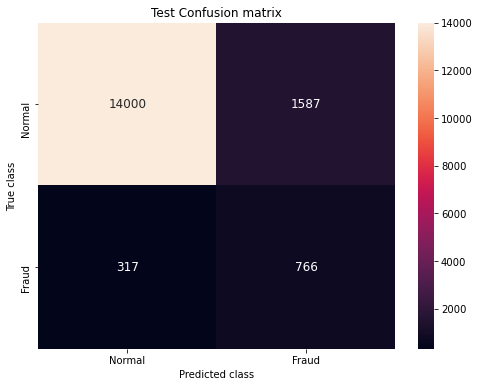

In [23]:
logs={}
res={}
f1_step={}
out={}
logs,f1_step,res,out = supervised_model('lr') 

### 2. Random Forest

Evaluation summary for rf
*********************************
For rf
Balanced Accuracy: 0.8599756
Macro Precision: 0.9702623
Macro Recall: 0.8599756
Macro F1: 0.9067013


Normal Accuracy: 0.979964
Normal Precision: 0.9595092
Normal Recall: 0.7220683
Normal F1: 0.8240253
Normal ROC-AUC: 0.8599756

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15587
           1       0.96      0.72      0.82      1083

    accuracy                           0.98     16670
   macro avg       0.97      0.86      0.91     16670
weighted avg       0.98      0.98      0.98     16670


None


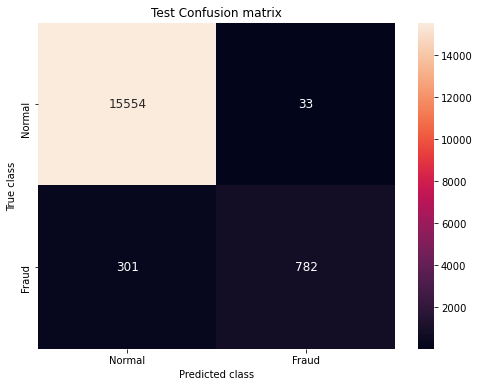

In [24]:
logs,f1_step,res,out = supervised_model('rf') 


### 3. XG Boost

Evaluation summary for xgb
*********************************
For xgb
Balanced Accuracy: 0.8539072
Macro Precision: 0.8969021
Macro Recall: 0.8539072
Macro F1: 0.8739597


Normal Accuracy: 0.9710258
Normal Precision: 0.8131524
Normal Recall: 0.7192982
Normal F1: 0.7633513
Normal ROC-AUC: 0.8539072

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     15587
           1       0.81      0.72      0.76      1083

    accuracy                           0.97     16670
   macro avg       0.90      0.85      0.87     16670
weighted avg       0.97      0.97      0.97     16670


None


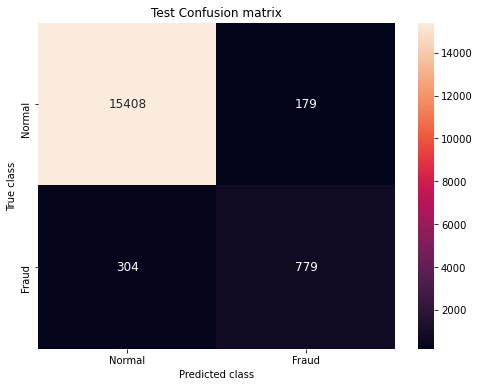

In [25]:
logs,f1_step,res,out = supervised_model('xgb') 

### Supervised baselines

In [26]:
logs_count = compute_count()
logs_all = list(out.values())
logs_score = [list(log.values()) for log in logs_all]
count = list(logs_count.values())
steps = range(35,50)

In [27]:
def plot_f1_score_step():
    plt.figure(figsize=(20,10))
    host = host_subplot(111, axes_class=AA.Axes)
    par1 = host.twinx()
    par1.axis["right"]
    par1.axis["right"].toggle(all=True)
    labels_list = ["LR","RF","XGB","LOF","IForest","EIForest","OneClassSVM","DBSCAN"]
    host.set_ylim([-0.05,1])
    host.set_xlim([34,50])

    host.set_xlabel("Time step")
    host.set_ylabel("F1  Illicit score")
    par1.set_ylabel("#Illicit")

    for logscr, label in zip(logs_score, labels_list):
        #print(logscr, label)
        host.plot(steps,logscr, label=label,linewidth=5)
    par1.bar(steps,count, label="#Illicit", color='yellow',edgecolor="grey",linewidth=2)

    host.legend(loc='upper right')
    #, bbox_to_anchor=(0.9, 0.8),fontsize=30)

    host.axis["bottom"].label.set_fontsize(30)
    host.axis["left"].label.set_fontsize(30)
    par1.axis["right"].label.set_fontsize(30)
    host.get_xaxis().set_tick_params(labelsize=30)
    host.get_yaxis().set_tick_params(labelsize=30)
    par1.get_yaxis().set_tick_params(labelsize=30)
    plt.draw()
    plt.savefig('/home/lax/UWMSDS/AnomalyDetection/images/Sup_Unsup.jpg');
    plt.show();

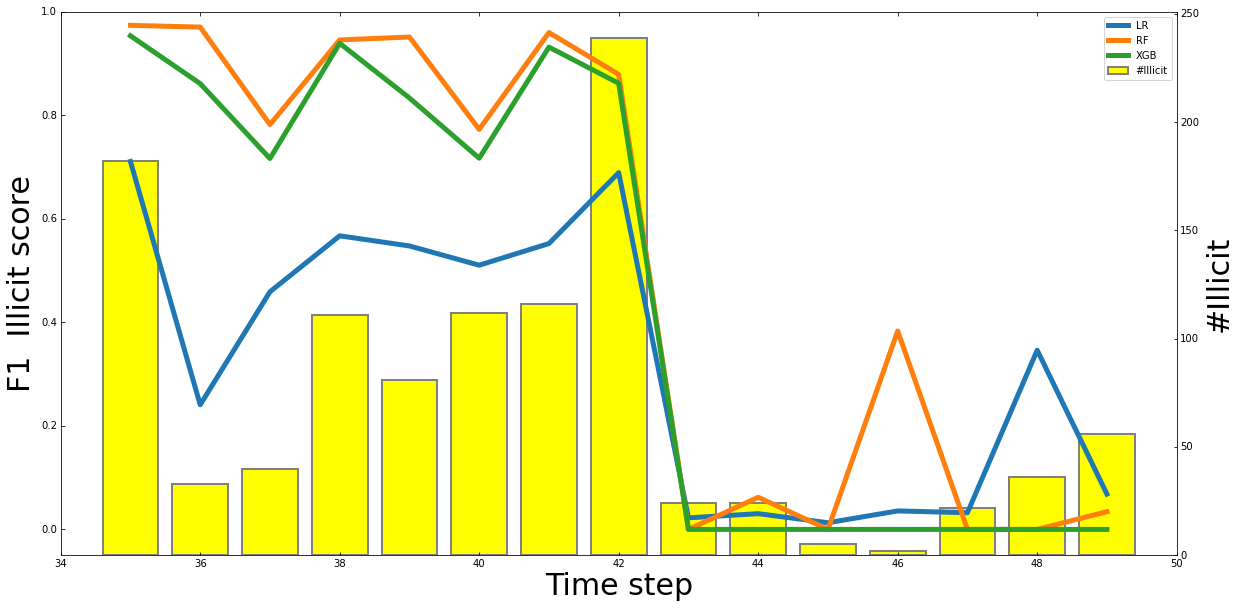

In [28]:
plot_f1_score_step()

We achieve an illicit F1-score on the test set of 0.76 for XGBoost, 0.45 for LR, and 0.83 for RF.
Thus, the best supervised baseline is achieved with the RF model. As
Weber et al. [41], we observe that model performance is profoundly
affected by a sudden dark market shutdown at time-step 43 (above figure).

In [29]:
model_avg_f1_score = {'XGBoost': np.mean(res['xgb']), 'Random Forest': np.mean(res['rf']),
                     'Logistic Regression': np.mean(res['lr'])}
print(model_avg_f1_score)

{'XGBoost': 0.763052311320574, 'Random Forest': 0.8258509937830517, 'Logistic Regression': 0.44586728754365546}


## Unsupervised methods

### 1. K-means clustering in PCA space

K-means clustering is a clustering analysis algorithm that groups objects based on their feature values into K
disjoint clusters. Objects that are classified into the same cluster have similar feature values. K is a positive integer number specifying the number of clusters, and has to be given in advance. Here are the four steps of the K-means clustering algorithm:
- Define the number of clusters K.
- Initialize the K cluster centroids. This can be done by arbitrarily dividing all objects into K clusters, computing their centroids, and verifying that all centroids are different from each other. Alternatively, the centroids can be initialized to K arbitrarily chosen, different objects.
- Iterate over all objects and compute the distances to the centroids of all clusters. Assign each object to the cluster with the nearest centroid.
- Recalculate the centroids of both modified clusters.
- Repeat step 3 until the centroids do not change any more.


A distance function is required in order to compute the distance (i.e. similarity) between two objects. The most commonly used distance function is the Euclidean one which is defined as:
d(x, y) = $ \sum_{i=1}^m (x_i - y_i)^2 $

where x = (x1, ..., xm) and y = (y1, ..., ym) are two input vectors with m quantitative features. In the Euclidean distance function, all features contribute equally to the function value. However, since different features are usually measured with different metrics or at different scales, they must be normalized before applying the distance function

We apply the K-means clustering algorithm to training datasets which may contain normal and anomalous traffic without being labeled as such in advance. The rationale behind this approach is the assumption that normal and anomalous traffic form different clusters in the features space. Of course, the data may contain outliers which do not belong to a bigger cluster, yet this does not disturb the K-means clustering process as long as the number of outliers is small.

In [30]:
from scipy.spatial.distance import cdist

def compute_outliers_l2norm(thresold_per,model,pca_scores):
    # obtaining the centers of the clusters
    centroids = model.cluster_centers_
    # points array will be used to reach the index easy
    data = pca_scores
    labels = model.labels_

    points = np.empty((0,len(data[0])), float)
    # distances will be used to calculate outliers
    distances = np.empty((0,len(data[0])), float)
    # getting points and distances
    for i, center_elem in enumerate(centroids):
        # cdist is used to calculate the distance between center and other points
        distances = np.append(distances, cdist([center_elem],data[labels == i], 'euclidean')) 
        points = np.append(points, data[labels == i], axis=0)
    # getting outliers whose distances are greater than some percentile
    indices = np.where(distances > np.percentile(distances, thresold_per))
    outliers = points[indices]
    return centroids,outliers,indices

In [31]:
def get_clusters(df,n_components):
    random_state=56
    model_pca=PCA(n_components=n_components)
    #df_pca = pd.DataFrame(df_nodetrans_feature_scaled, columns=df_node_feature.columns)
    df_pca = df
    pca_scores = model_pca.fit_transform(df_pca)
    print("pca_scores shape",pca_scores.shape)
    
    wcss=[] # within cluster sum of squares
    for i in range(1,12):
        kmeans_pca=KMeans(n_clusters=i,init='k-means++',random_state=42)
        kmeans_pca.fit(pca_scores)
        wcss.append(kmeans_pca.inertia_)

    plt.figure(figsize=(8,4))
    plt.plot(range(1,12), wcss, marker='o',linestyle='--')
    plt.title('k-means with pca',fontsize=15)
    plt.xlabel('Number of clusters',fontsize=15)
    plt.ylabel('within cluster sum of squares',fontsize=15)
    plt.tick_params(labelsize=10)

    #df_pca_full.head()
    return pca_scores,df_pca,model_pca

In [32]:
def pca_kmeans_data(df,n_components, clusters):
    pca_scores,df_pca,model_pca=get_clusters(df,n_components)
    kmeans = KMeans(clusters,init='k-means++',random_state=42)
    kmeans.fit(pca_scores)
    labels = kmeans.labels_ # labels associated with each data point or index of the cluster 
    #centroid that is closest to x(i)


    #cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = ['pca1','pca2','pca3'])
    cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_)

    map_dict = dict([(i,"cluster"+str(i+1)) for i in range(clusters)])

    df_pca_kmean_seg = pd.concat([df_pca.reset_index(drop=True),pd.DataFrame(pca_scores),\
                                  pd.DataFrame(X_train_copy['class']).reset_index(drop=True)],axis=1) # remove
    
    df_pca_kmean_seg.columns.values[-(n_components + 1):-1] = ["pca"+str(i) for i in range(n_components)]# remove this
    df_pca_kmean_seg.columns.values[-1:] = ['class'] # remove this
    df_pca_kmean_seg['seg_labels'] = labels
    df_pca_kmean_seg['Segment'] = df_pca_kmean_seg['seg_labels'].map(map_dict)

    return df_pca_kmean_seg,kmeans,pca_scores,model_pca

In [33]:
def plot_kmeans_anomalies(df_pca_kmean_seg,centroids,outliers,true_anomalies,clusters):
    
    if clusters == 2:
        palette = ['orange','grey']
    if clusters == 3:
        palette = ['orange','grey','pink']
    if clusters == 4:
        palette = ['orange','grey','pink','brown']
    if clusters == 5:
        palette = ['orange','grey','pink','brown','yellow']
    if clusters == 6:
        palette = ['orange','grey','pink','brown','yellow','gold']
        
    f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(35,8))
    sns.set_context("notebook", font_scale=2, rc={"lines.linewidth":3})

    sns.scatterplot(x="pca1", y="pca2", hue = "Segment", data = df_pca_kmean_seg, \
                    legend=False,s=150,palette =palette,ax=ax1)
    ax1.scatter(*zip(*outliers[:,:2]),marker="o",facecolor="b",edgecolor="black",s=80,label="outlier")
    ax1.scatter(*zip(*centroids[:,:2]),marker="x",facecolor="r",edgecolor="black",s=200,label="centroid")
    ax1.scatter(*zip(*true_anomalies[:,:2]),marker="o",facecolor="green",edgecolor="black",s=80,label="anomaly")
    #ax1.legend(bbox_to_anchor=(1.05, 1), loc=4, borderaxespad=0.)

    sns.scatterplot(x="pca2", y="pca3", hue = "Segment", data = df_pca_kmean_seg, \
                    legend=False,s=150,palette =palette,ax=ax2)
    ax2.scatter(*zip(*outliers[:,1:3]),marker="o",facecolor="b",edgecolor="black",s=80,label="outlier")
    ax2.scatter(*zip(*centroids[:,1:3]),marker="x",facecolor="r",edgecolor="black",s=200,label="centroid")
    ax2.scatter(*zip(*true_anomalies[:,1:3]),marker="o",facecolor="green",edgecolor="black",s=80,label="anomaly")
    #ax2.legend(bbox_to_anchor=(1.05, 1), loc=4, borderaxespad=0.)

    sns.scatterplot(x="pca1", y="pca3", hue = "Segment", data = df_pca_kmean_seg, \
                    s=150,palette =palette,ax=ax3)
    ax3.scatter(*zip(*outliers[:,[0,2]]),marker="o",facecolor="b",edgecolor="black",s=80,label="outlier")
    ax3.scatter(*zip(*centroids[:,[0,2]]),marker="x",facecolor="r",edgecolor="black",s=200,label="centroid")
    ax3.scatter(*zip(*true_anomalies[:,[0,2]]),marker="o",facecolor="green",edgecolor="black",s=80,label="anomaly")

    #ax3.legend(bbox_to_anchor=(1.05, 1), loc=4, borderaxespad=0.,fontsize=30)
    ax3.legend(loc='upper right',fontsize=30)
    #plt.grid()
    ax1.tick_params(labelsize=30)
    ax2.tick_params(labelsize=30)
    ax3.tick_params(labelsize=30)
    plt.tight_layout()

In [34]:
def pca_loadings(model_pca,df_pca_kmean_seg,col_range):
    xvector = model_pca.components_[0]  
    yvector = model_pca.components_[1]
    zvector = model_pca.components_[2]
    print(xvector.shape)

    df_loadings = df_pca_kmean_seg.iloc[:, col_range].copy()
    #print(zvector.shape)
    #print(df_loadings.shape)
    #loadings = pd.DataFrame(model_pca.components_.T, columns=['PC1', 'PC2','PC3'], index=df_loadings.columns.values)
    pca_components = pd.DataFrame({'Variables':df_loadings.columns.values,'PCA1 Loadings': xvector,\
                                   'PCA2 Loadings': yvector, 'PCA3 Loadings': zvector})
    return pca_components
    #pca_components.head()

## K means with PCA with all features

In [35]:
model=PCA()
df_pca = X_train.copy()

#.loc[:,subset_cols]
model.fit_transform(df_pca)

len(model.explained_variance_ratio_.cumsum())

165

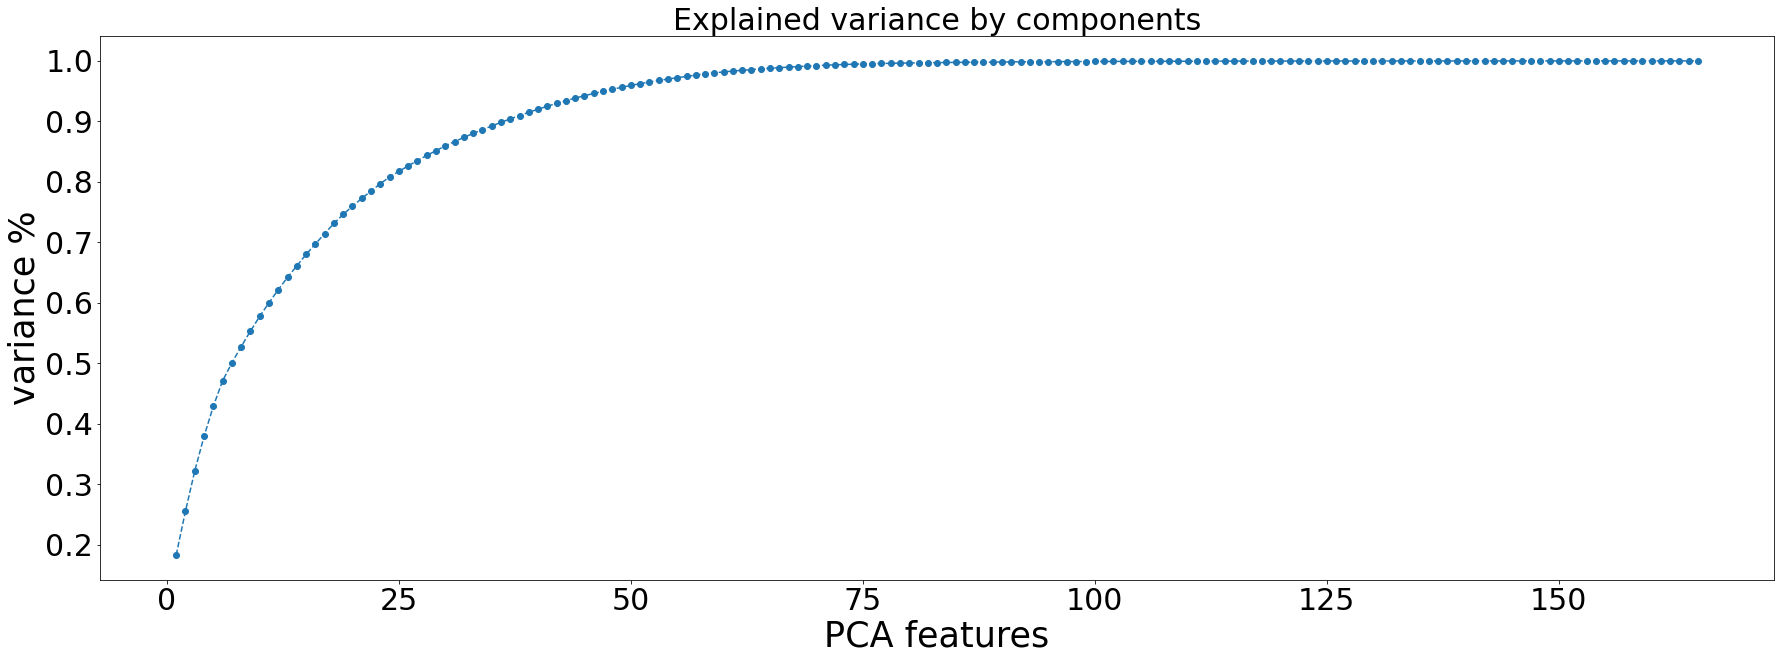

In [36]:
# Plot the explained variances
plt.figure(figsize=(30,10))
plt.plot(range(1,166), model.explained_variance_ratio_.cumsum(), marker='o',linestyle='--')
plt.title('Explained variance by components',fontsize=30)
plt.xlabel('PCA features', fontsize = 35)
plt.ylabel('variance %', fontsize = 35)

plt.tick_params(labelsize=30)

pca_scores shape (29894, 50)
 Anomalies which are outliers:  42


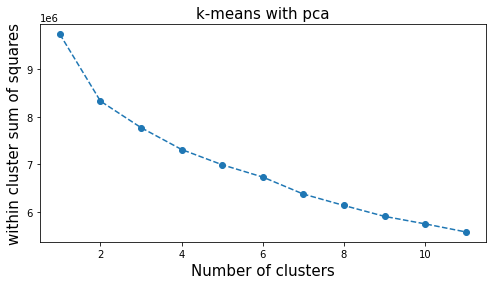

In [37]:
thresold_per=99
df_pca = X_train.copy()
#.loc[:,subset_cols]
df_pca_kmean_seg, model_kmeans, pca_scores_train,model_pca = pca_kmeans_data(df_pca,n_components=50, clusters=2)
centroids,outliers,indices = compute_outliers_l2norm(thresold_per,model_kmeans,pca_scores_train) 
true_anomalies = pca_scores_train[df_pca_kmean_seg['class'] == '1']
df_pca_kmean_seg["outliers"] = 0
for indx in indices:
    df_pca_kmean_seg.loc[indx,"outliers"] = 1
out_anom = df_pca_kmean_seg[(df_pca_kmean_seg["outliers"] == 1) & (df_pca_kmean_seg["class"] == '1')]
print(" Anomalies which are outliers: ", out_anom.shape[0])

(165,)


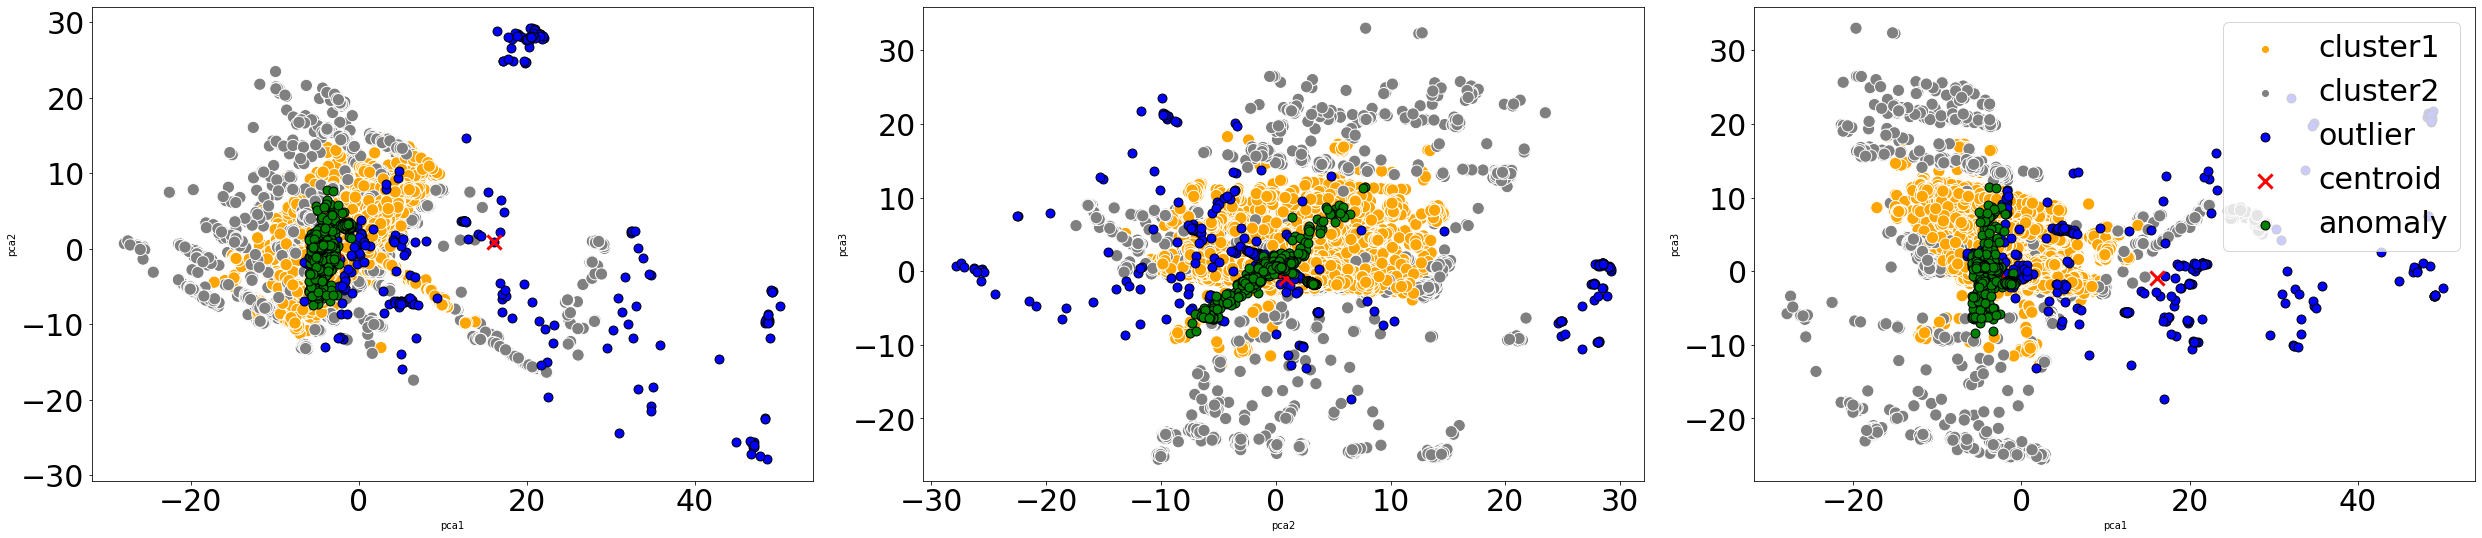

In [38]:
clusters=2
plot_kmeans_anomalies(df_pca_kmean_seg,centroids,outliers,true_anomalies,clusters)
col_range= range(0,165)
pca_components_full = pca_loadings(model_pca,df_pca_kmean_seg,col_range)
plt.savefig('/home/lax/UWMSDS/AnomalyDetection/images/PCA_Kmeans_allFeatures.jpg');

In [39]:
print("Predicted on train set with K="+str(clusters))
normal_count = pd.value_counts(y_train)[0]
fraud_count = pd.value_counts(y_train)[1]
pred_train = model_kmeans.predict(pca_scores_train)
loc = 0
countdict = {}
anomaly_tag = []
mal_locs = set(np.where(y_train == 1)[0])
for loc, pred in enumerate(pred_train):
    if loc in mal_locs:
        countdict[pred] = countdict.get(pred, 0) + 1
        anomaly_tag.append(1)
    else:
        anomaly_tag.append(0)
        
for key, value in sorted(countdict.items()):
    non_mal = len((np.where(pred_train == key)[0])) - value
    
    print('Cluster '+str(key+1)+': \t Malicious: '+str(value)+ \
          ' ('+str(round((value*100)/fraud_count,3))+'%)' +' \t Non-Malicious: '\
          +str(non_mal)+' ('+str(round((non_mal*100)/normal_count,3))+'%)\n') 

Predicted on train set with K=2
Cluster 1: 	 Malicious: 3462 (100.0%) 	 Non-Malicious: 21891 (82.82%)



In [40]:
model_test=PCA(n_components=50)
df_pca_test = X_test.copy()
#.loc[:,subset_cols]
pca_scores_test = model_test.fit_transform(df_pca_test)

In [41]:
print("Predicted on test set with K="+str(clusters))
normal_count = pd.value_counts(y_test)[0]
fraud_count = pd.value_counts(y_test)[1]
pred_test = model_kmeans.predict(pca_scores_test)
loc = 0
countdict = {}
mal_locs = set(np.where(y_test == 1)[0])
for loc, pred in enumerate(pred_test):
    if loc in mal_locs:
        countdict[pred] = countdict.get(pred, 0) + 1
        
for key, value in sorted(countdict.items()):
    non_mal = len((np.where(pred_test == key)[0])) - value
    
    print('Cluster '+str(key+1)+': \t Malicious: '+str(value)+ \
          ' ('+str(round((value*100)/fraud_count,3))+'%)' +' \t Non-Malicious: '\
          +str(non_mal)+' ('+str(round((non_mal*100)/normal_count,3))+'%)\n')  

Predicted on test set with K=2
Cluster 1: 	 Malicious: 1083 (100.0%) 	 Non-Malicious: 15026 (96.401%)



In [42]:
print('Train Cluster Result:\n')
print(pd.value_counts(pred_train))

print('\n\nTest Cluster Result:\n')
print(pd.value_counts(pred_test))

Train Cluster Result:

0    25353
1     4541
dtype: int64


Test Cluster Result:

0    16109
1      561
dtype: int64


In [43]:
print("Train Evaluation Summary\n******************\n")
print(evaluation_summary(y_train, pred_train, 'K-means (K='+str(clusters)+')'))

print("Test Evaluation Summary\n******************\n")
print(evaluation_summary(y_test, pred_test, 'K-means (K='+str(clusters)+')'))

Train Evaluation Summary
******************

For K-means (K=2)
Balanced Accuracy: 0.4141003
Macro Precision: 0.4317241
Macro Recall: 0.4141003
Macro F1: 0.4227286


Normal Accuracy: 0.7322874
Normal Precision: 0.0
Normal Recall: 0.0
Normal F1: 0.0
Normal ROC-AUC: 0.4141003

              precision    recall  f1-score   support

           0       0.86      0.83      0.85     26432
           1       0.00      0.00      0.00      3462

    accuracy                           0.73     29894
   macro avg       0.43      0.41      0.42     29894
weighted avg       0.76      0.73      0.75     29894


None
Test Evaluation Summary
******************

For K-means (K=2)
Balanced Accuracy: 0.4820042
Macro Precision: 0.4663853
Macro Recall: 0.4820042
Macro F1: 0.4740661


Normal Accuracy: 0.9013797
Normal Precision: 0.0
Normal Recall: 0.0
Normal F1: 0.0
Normal ROC-AUC: 0.4820042

              precision    recall  f1-score   support

           0       0.93      0.96      0.95     15587
         

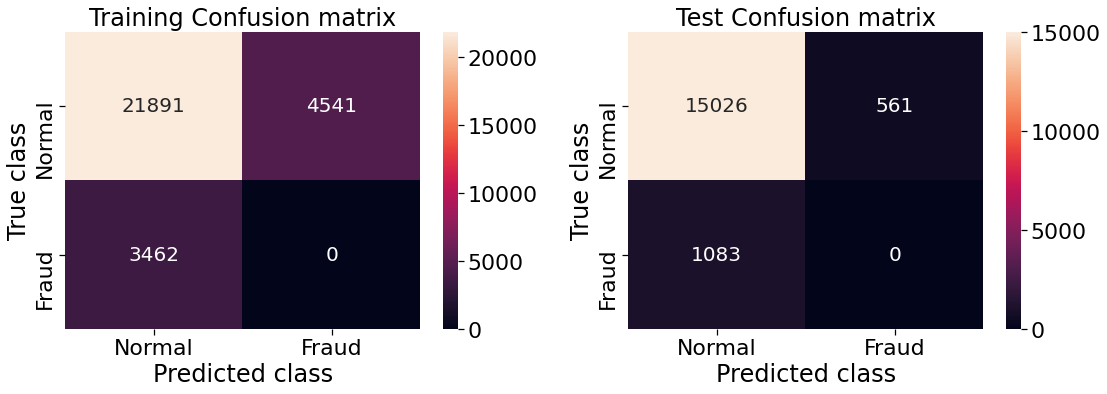

In [44]:
cnf_mtx_test = confusion_matrix(y_test, pred_test)
cnf_mtx_train = confusion_matrix(y_train, pred_train)
conf_matrix_normal(cnf_mtx_train, cnf_mtx_test)
plt.savefig('/home/lax/UWMSDS/AnomalyDetection/images/PCA_Kmeans_allFeatures_conf_matrix.jpg');

## Feature extraction

When the number of principal components equals the number of original dimensions, PCA captures nearly 100% of the variance/information in the data as it generates the principal components. Therefore, when PCA reconstructs the transactions from the principal components, it will have too little reconstruction error for all the transactions, fraudulent or otherwise. We will not be able to differentiate between rare transactions and normal ones—in other words, anomaly detection will be poor

For PCA, the reconstruction error will depend largely on the number of principal components we keep and use to reconstruct the original transactions. The more principal components we keep, the better PCA will be at learning the underlying structure of the original transactions.

However, there is a balance. If we keep too many principal components, PCA may too easily reconstruct the original transactions, so much so that the reconstruction error will be minimal for all of the transactions. If we keep too few principal components, PCA may not be able to reconstruct any of the original transactions well enough—not even the normal, nonfraudulent transactions.

### Distribution of features

Text(0.5, 0.98, 'Fraudulent Transactions (Red) VS Normal Transactions (Blue)')

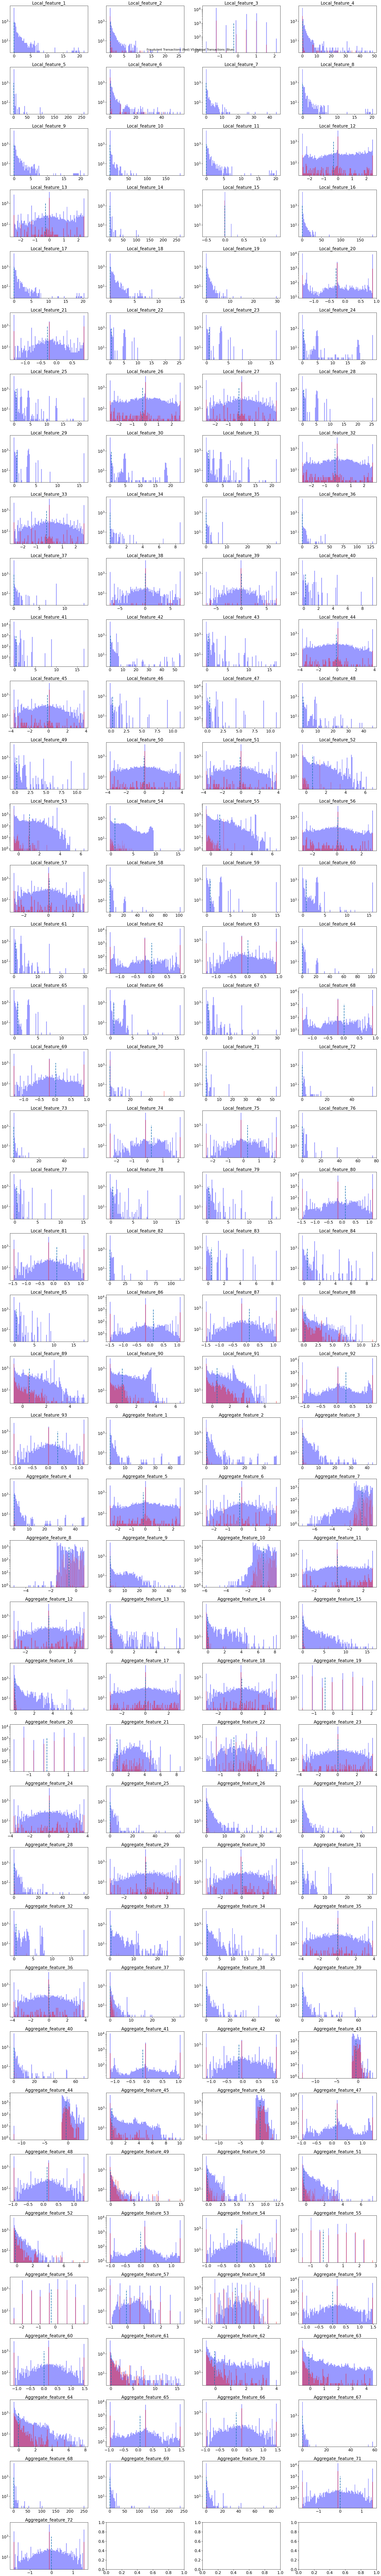

In [45]:
'''
    distribution of features 
    red: fraudulent transactions
    blue: otherwise
'''
ncols = 4

data = X_train
data= data.reset_index(drop=True)
fig2, axes = plt.subplots(nrows=42, ncols=ncols , constrained_layout=True, figsize=(30, 200))

for i,col in enumerate(data.columns):
    m = int(np.floor((i)/ncols))
    n = (i)%ncols
    axes[m,n].hist(data[y_train==0][col], bins=100, alpha=0.4, color='b');
    axes[m,n].hist(data[y_train==1][col], bins=100, alpha=0.4, color='r');
    axes[m,n].set_title(col)
    axes[m,n].vlines(x=data[col].mean(),ymin=0, ymax=10**3, linestyles='dashed')
    axes[m,n].set_yscale('log')

plt.tight_layout()
fig2.suptitle('Fraudulent Transactions (Red) VS Normal Transactions (Blue)', fontsize=16)


We identify  the below 29 features manually from the PCA distribution. Features which appear to have red area (fraud) separate from blue(non-fraud) help identify anomalies better.

In [46]:
local = [2,3,4,6,15,39,52,53,55,70,88,85,89,90,91]
agg = [2,19,21,22,43,44,45,46,49,52,55,58,61,20]
colNames1 = {"Local_feature_" + str(i) for i in local }
colNames2 = {"Aggregate_feature_" + str(j) for j in agg}
#combine dictionaries
colNames = [*colNames1, *colNames2]

In [47]:
len(colNames)

29

In [48]:
dataX=X_train.loc[:,colNames]

In [49]:
pca_std = PCA(n_components=29).fit(dataX)
dataX = pca_std.transform(dataX)
dataX = pd.DataFrame(dataX)
dataX.columns = sorted(colNames)
data = dataX

In [50]:
ncols = 4
mean_diff={}
var_diff={}
for i,col in enumerate(dataX.columns):
    m = int(np.floor((i)/ncols))
    n = (i)%ncols
    mean_diff[col] = abs(np.mean(data[y_train==0][col])-np.mean(data[y_train==1][col]))
    var_diff[col] = abs(np.var(data[y_train==0][col])-np.var(data[y_train==1][col]))

In [51]:
diff = list(sorted(mean_diff.items(),key=lambda x :-x[1]))
#[item[0] for item in diff]

In [52]:
diff=sorted(var_diff.items(),key=lambda x :-x[1])
#[item for item in diff]

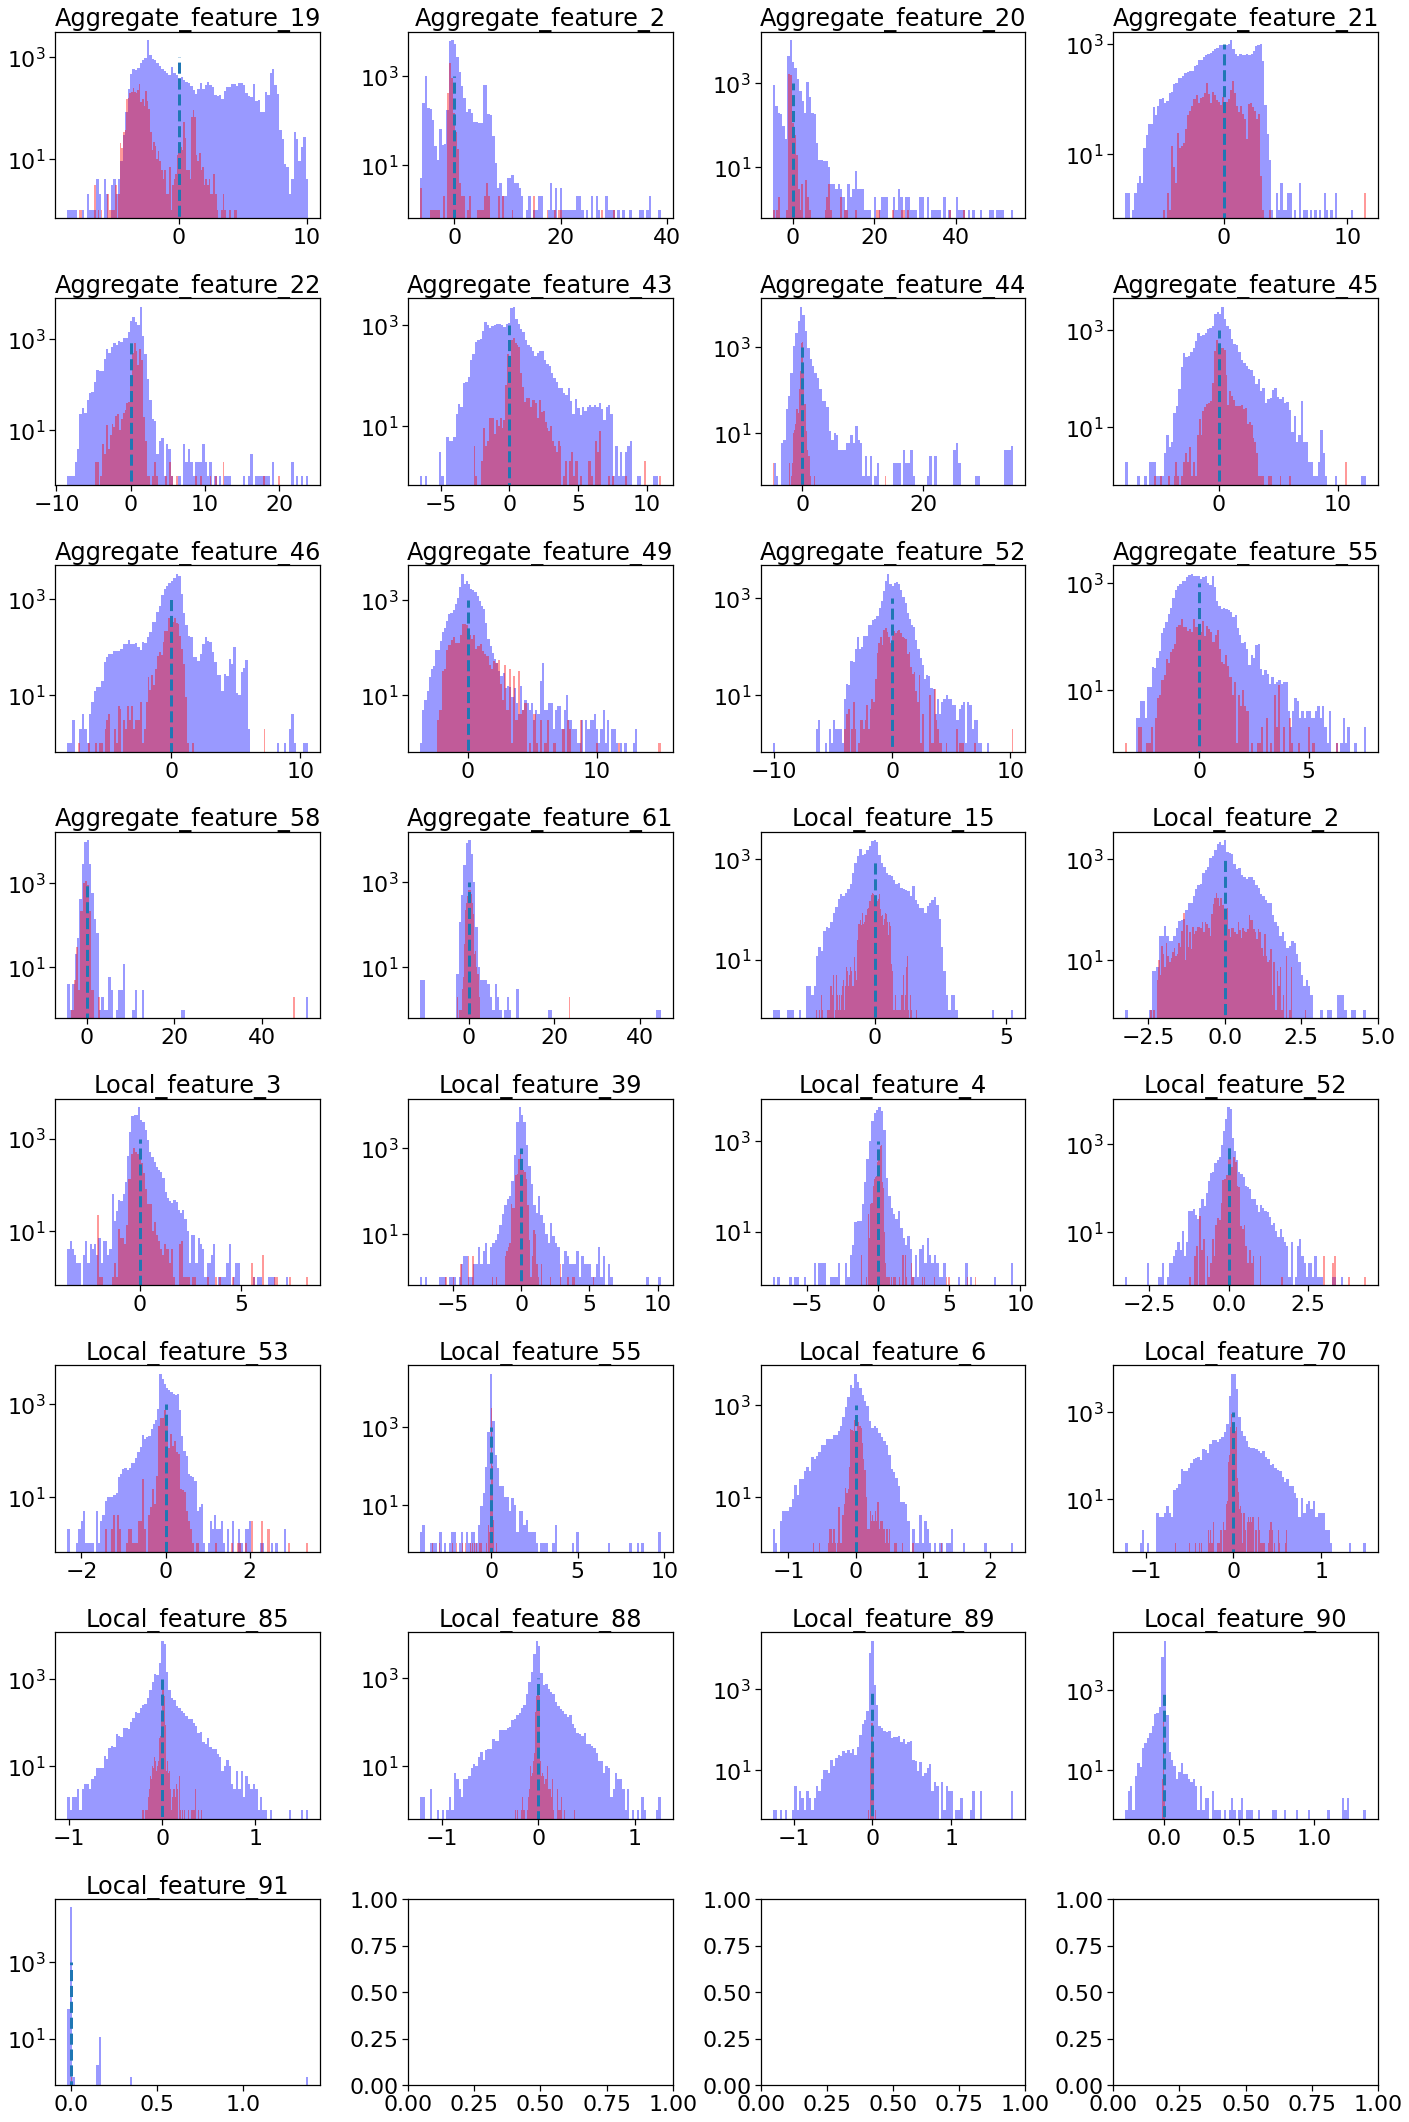

In [53]:
'''
    distribution of features 
    red: fraudulent transactions
    blue: otherwise
'''
ncols = 4

data = dataX
data= data.reset_index(drop=True)
fig2, axes = plt.subplots(nrows=8, ncols=ncols , constrained_layout=True, figsize=(20, 30))


for i,col in enumerate(data.columns):
    m = int(np.floor((i)/ncols))
    n = (i)%ncols
    axes[m,n].hist(data[y_train==0][col], bins=100, alpha=0.4, color='b');
    axes[m,n].hist(data[y_train==1][col], bins=100, alpha=0.4, color='r');
    axes[m,n].set_title(col)
    axes[m,n].vlines(x=data[col].mean(),ymin=0, ymax=10**3, linestyles='dashed')
    axes[m,n].set_yscale('log')

plt.tight_layout()
#fig2.suptitle('Fraudulent Transactions (Red) VS Normal Transactions (Blue)', fontsize=16)


In [54]:
#local =[53,52,55,3,15]
#agg=[19,2,20,21,43,55,45,52,49,46,58,61]
local=[2,15,3]
agg=[19,22,2,43,20,21,61,58,49,45,52,55,44,46]

In [55]:
#agg = [2,43,45,55,52,49,46,58,61]
#local=[2,52,70,6,4,55,85,53,69]
colNames1 = {"Local_feature_" + str(i) for i in local }
colNames2 = {"Aggregate_feature_" + str(j) for j in agg}
#combine dictionaries
colNames = [*colNames1, *colNames2]
print(colNames)
len(colNames)

['Local_feature_2', 'Local_feature_3', 'Local_feature_15', 'Aggregate_feature_43', 'Aggregate_feature_19', 'Aggregate_feature_22', 'Aggregate_feature_61', 'Aggregate_feature_49', 'Aggregate_feature_44', 'Aggregate_feature_46', 'Aggregate_feature_52', 'Aggregate_feature_21', 'Aggregate_feature_45', 'Aggregate_feature_55', 'Aggregate_feature_20', 'Aggregate_feature_58', 'Aggregate_feature_2']


17

### Kmeans with PCA after feature selection

pca_scores shape (29894, 15)
 Anomalies which are outliers:  46
 Non anomalies which are outliers:  253


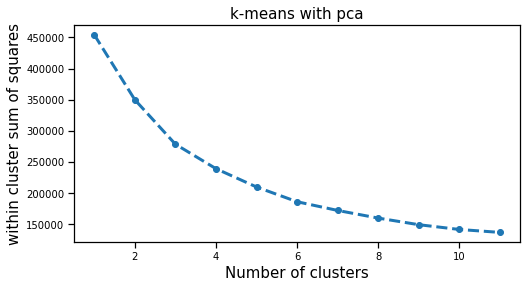

In [56]:
thresold_per=99
n_components =15
df_pca_subset = X_train.loc[:,colNames]
#df_pca_subset = X_train.iloc[:,selected_features]
#df_pca = X_train.loc[:,subset_cols]
df_pca_kmean_seg_subset, model_kmeans_subset, pca_scores_subset,model_pca_subset \
    = pca_kmeans_data(df_pca_subset,n_components=n_components, clusters=2)
centroids,outliers,indices\
    = compute_outliers_l2norm(thresold_per,model_kmeans_subset,pca_scores_subset) 
true_anomalies = pca_scores_subset[df_pca_kmean_seg_subset['class'] == '1']
df_pca_kmean_seg_subset["outliers"] = 0
for indx in indices:
    df_pca_kmean_seg_subset.loc[indx,"outliers"] = 1
out_anom = df_pca_kmean_seg_subset[(df_pca_kmean_seg_subset["outliers"] == 1) & (df_pca_kmean_seg_subset["class"] == '1')]
print(" Anomalies which are outliers: ", out_anom.shape[0])
out_nonanom = df_pca_kmean_seg_subset[(df_pca_kmean_seg_subset["outliers"] == 1) & (df_pca_kmean_seg_subset["class"] == '2')]
print(" Non anomalies which are outliers: ", out_nonanom.shape[0])

(17,)


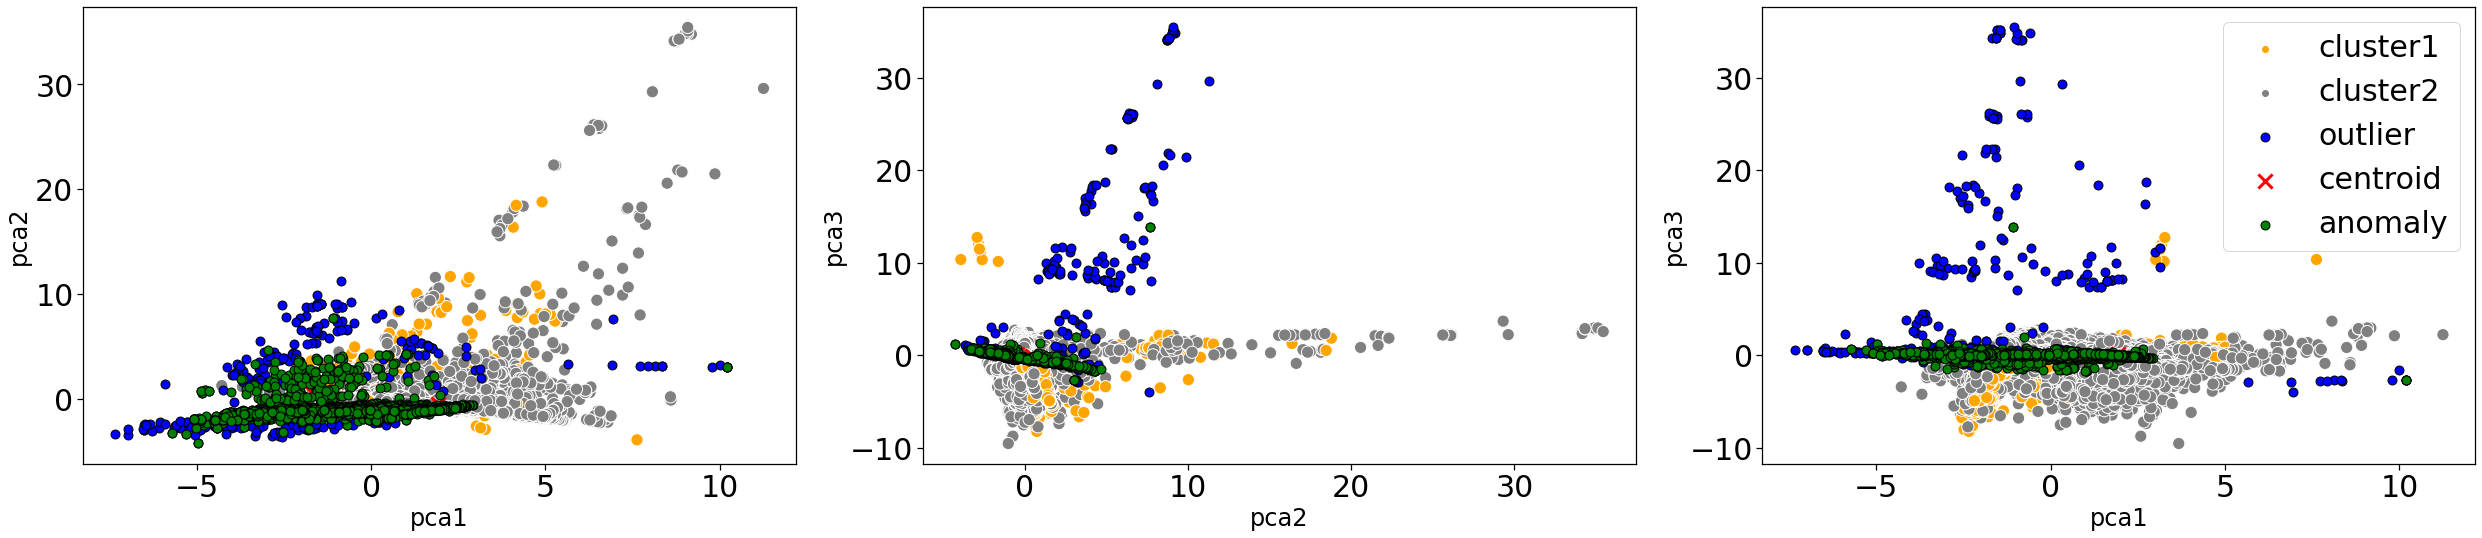

In [57]:
clusters = 2
plot_kmeans_anomalies(df_pca_kmean_seg_subset,centroids,outliers,true_anomalies,clusters=clusters)
col_range= range(0,17)
pca_components_set1 = pca_loadings(model_pca_subset,df_pca_kmean_seg_subset,col_range)
#plt.savefig('C:/Users/Lakshmi/Desktop/UW DataScience application/CSE547/Project/images/PCA_Kmeans_subsetFeatures.jpg');

In [58]:
print("Predicted on train set with K="+str(clusters))
normal_count = pd.value_counts(y_train)[0]
fraud_count = pd.value_counts(y_train)[1]
pred_train = model_kmeans_subset.predict(pca_scores_subset)
loc = 0
countdict = {}
anomaly_tag = []
mal_locs = set(np.where(y_train == 1)[0])
for loc, pred in enumerate(pred_train):
    if loc in mal_locs:
        countdict[pred] = countdict.get(pred, 0) + 1
        anomaly_tag.append(1)
    else:
        anomaly_tag.append(0)
        
for key, value in sorted(countdict.items()):
    non_mal = len((np.where(pred_train == key)[0])) - value
    
    print('Cluster '+str(key+1)+': \t Malicious: '+str(value)+ \
          ' ('+str(round((value*100)/fraud_count,3))+'%)' +' \t Non-Malicious: '\
          +str(non_mal)+' ('+str(round((non_mal*100)/normal_count,3))+'%)\n') 

Predicted on train set with K=2
Cluster 1: 	 Malicious: 1288 (37.204%) 	 Non-Malicious: 12612 (47.715%)

Cluster 2: 	 Malicious: 2174 (62.796%) 	 Non-Malicious: 13820 (52.285%)



In [59]:
model_pca_subset_test=PCA(n_components=15)
df_pca_subset_test = X_test.loc[:,colNames]
#df_pca_subset_test = X_test.iloc[:,selected_features]
pca_scores_subset_test = model_pca_subset_test.fit_transform(df_pca_subset_test)

In [60]:
print("Predicted on test set with K="+str(clusters))
normal_count = pd.value_counts(y_test)[0]
fraud_count = pd.value_counts(y_test)[1]
pred_test = model_kmeans_subset.predict(pca_scores_subset_test)
loc = 0
countdict = {}
mal_locs = set(np.where(y_test == 1)[0])
for loc, pred in enumerate(pred_test):
    if loc in mal_locs:
        countdict[pred] = countdict.get(pred, 0) + 1
        
for key, value in sorted(countdict.items()):
    non_mal = len((np.where(pred_test == key)[0])) - value
    
    print('Cluster '+str(key+1)+': \t Malicious: '+str(value)+ \
          ' ('+str(round((value*100)/fraud_count,3))+'%)' +' \t Non-Malicious: '\
          +str(non_mal)+' ('+str(round((non_mal*100)/normal_count,3))+'%)\n')  

Predicted on test set with K=2
Cluster 1: 	 Malicious: 58 (5.355%) 	 Non-Malicious: 3083 (19.779%)

Cluster 2: 	 Malicious: 1025 (94.645%) 	 Non-Malicious: 12504 (80.221%)



In [61]:
print('For K='+str(clusters))
merge = [1]

prediction = pred_test.copy()
t_prediction = pred_train.copy()


for i in range(0,clusters):
    if (i+1) in merge:
        prediction[prediction == i] = -1
        t_prediction[t_prediction == i] = -1
    else:
        prediction[prediction == i] = 0
        t_prediction[t_prediction == i] = 0

prediction[prediction == -1] = 1
t_prediction[t_prediction == -1] = 1

print('Train Cluster Merge Result:\n')
print(pd.value_counts(t_prediction))

print('\n\nTest Cluster Merge Result:\n')
print(pd.value_counts(prediction))

For K=2
Train Cluster Merge Result:

0    15994
1    13900
dtype: int64


Test Cluster Merge Result:

0    13529
1     3141
dtype: int64


In [62]:
print("Train Evaluation Summary\n******************")
print(evaluation_summary(y_train, t_prediction, 'K-means (K='+str(clusters)+')'))
print("Test Evaluation Summary\n******************")
print(evaluation_summary(y_test, prediction, 'K-means (K='+str(clusters)+')'))

Train Evaluation Summary
******************
For K-means (K=2)
Balanced Accuracy: 0.4474452
Macro Precision: 0.4783679
Macro Recall: 0.4474452
Macro F1: 0.3999286


Normal Accuracy: 0.5053857
Normal Precision: 0.0926619
Normal Recall: 0.3720393
Normal F1: 0.14837
Normal ROC-AUC: 0.4474452

              precision    recall  f1-score   support

           0       0.86      0.52      0.65     26432
           1       0.09      0.37      0.15      3462

    accuracy                           0.51     29894
   macro avg       0.48      0.45      0.40     29894
weighted avg       0.77      0.51      0.59     29894


None
Test Evaluation Summary
******************
For K-means (K=2)
Balanced Accuracy: 0.427881
Macro Precision: 0.4713511
Macro Recall: 0.427881
Macro F1: 0.4431857


Normal Accuracy: 0.7535693
Normal Precision: 0.0184655
Normal Recall: 0.0535549
Normal F1: 0.0274621
Normal ROC-AUC: 0.427881

              precision    recall  f1-score   support

           0       0.92      0.80 

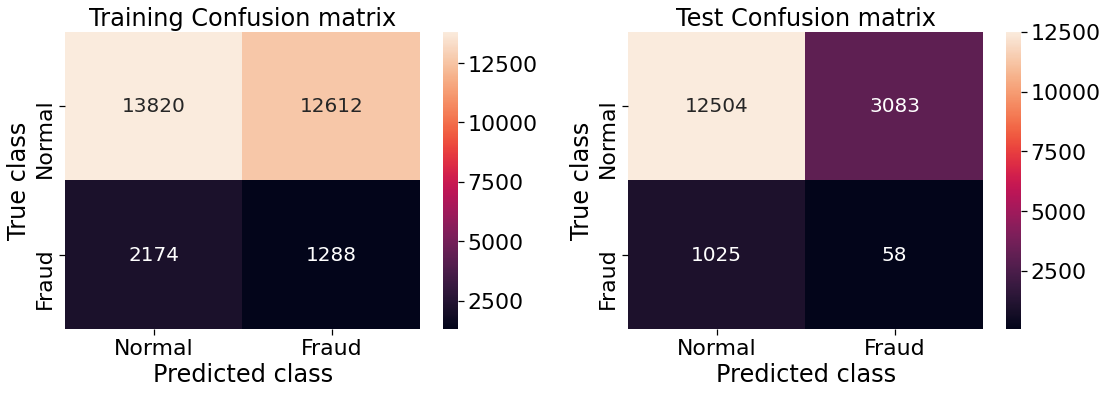

In [63]:
cnf_mtx_test = confusion_matrix(y_test, prediction)
cnf_mtx_train = confusion_matrix(y_train, t_prediction)
conf_matrix_normal(cnf_mtx_train, cnf_mtx_test)
plt.savefig('/home/lax/UWMSDS/AnomalyDetection/images/PCA_Kmeans_subFeatures_conf_matrix.jpg');

## 2.  PCA + Mahanalobis distance

As dealing with high dimensional sensor data is often challenging, there are several techniques to reduce the number of variables (dimensionality reduction). 

The Mahalanobis distance is widely used in cluster analysis and classification techniques. In order to use the Mahalanobis distance to classify a test point as belonging to one of N classes, one first estimates the covariance matrix of each class, usually based on samples known to belong to each class. In our case, as we are only interested in classifying “normal” vs “anomaly”, we use training data to calculate the covariance matrix. Then, given a test sample, we compute the Mahalanobis distance to the “normal” class, and classifies the test point as an “anomaly” if the distance is above a certain threshold.

In [64]:
df_X = X_all.drop(['class','Time step'],axis=1).copy()
df_y = y_all.copy()

In [65]:
train_X = df_X.loc[:,colNames][df_y == 0]
test_X = df_X.loc[:,colNames][df_y == 1]
scaler = preprocessing.MinMaxScaler()
train_X = pd.DataFrame(scaler.fit_transform(train_X), 
                              columns=train_X.columns, 
                              index=train_X.index)
# Random shuffle training data
train_X.sample(frac=1)
test_X = pd.DataFrame(scaler.transform(test_X), 
                             columns=test_X.columns, 
                             index=test_X.index)

In [66]:
model_pca_md =PCA(n_components=15)
train_subset = train_X.loc[:,colNames]
test_subset = test_X.loc[:,colNames]
df_pca_train = train_subset
df_pca_test = test_subset
pca_scores_train = model_pca_md.fit_transform(df_pca_train)
pca_scores_test = model_pca_md.fit_transform(df_pca_test)

In [67]:
pca_scores_train = pd.DataFrame(pca_scores_train)
pca_scores_train.index = train_subset.index

pca_scores_test = pd.DataFrame(pca_scores_test)
pca_scores_test.index = test_subset.index

In [68]:
data_train = np.array(pca_scores_train.values)
data_test = np.array(pca_scores_test.values)

In [69]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [70]:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [71]:
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    diff = data - mean_distr
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

In [72]:
def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [73]:
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

In [74]:
cov_matrix, inv_cov_matrix  = cov_matrix(data_train)
mean_distr = np.mean(data_train,axis=0)

In [75]:
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)
print(threshold)

9.79294017766294


Text(0.5, 0, 'Mahalanobis dist')

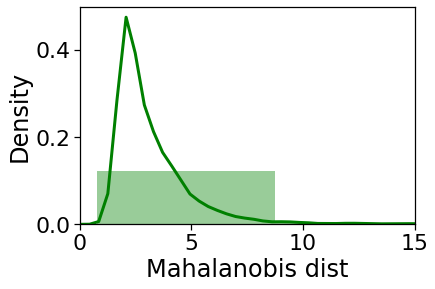

In [76]:
plt.figure()
sns.distplot(dist_train,
             bins = 10, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,15])
plt.xlabel('Mahalanobis dist')

In [77]:
anomaly_train = pd.DataFrame()
anomaly_train['Mahanolobis distance']= dist_train
anomaly_train['Threshold'] = threshold
# If Mahanolobis distance above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mahanolobis distance'] > anomaly_train['Threshold']
anomaly_train.index = pca_scores_train.index

anomaly_test = pd.DataFrame()
anomaly_test['Mahanolobis distance']= dist_test
anomaly_test['Threshold'] = threshold
# If Mahanolobis distance above threshold: Flag as anomaly
anomaly_test['Anomaly'] = anomaly_test['Mahanolobis distance'] > anomaly_test['Threshold']
anomaly_test.index = pca_scores_test.index
anomaly_test.head()

,Mahanolobis distance,Threshold,Anomaly
906,1.570176,9.79294,False
1360,5.601674,9.79294,False
2717,4.796175,9.79294,False
2814,3.791432,9.79294,False
3422,7.042891,9.79294,False


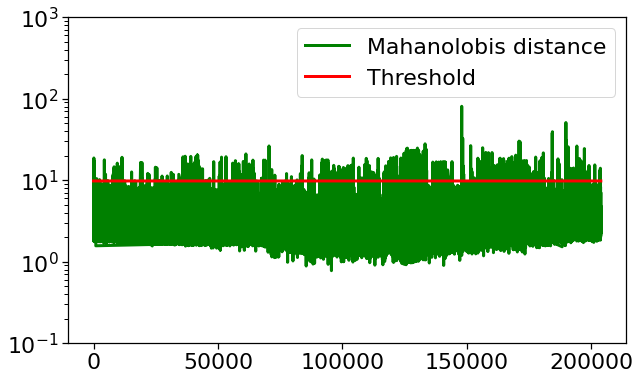

In [78]:
anomaly_alldata = pd.concat([anomaly_train, anomaly_test])
anomaly_alldata.plot(logy=True, figsize = (10,6), ylim = [1e-1,1e3], color = ['green','red']);

In [79]:
y_train_pred = anomaly_train['Anomaly'].copy()
y_train_pred[y_train_pred == False] = 0
y_train_pred[y_train_pred == True] = 1

In [80]:
pd.value_counts(y_train_pred)

0.0    41354
1.0      665
Name: Anomaly, dtype: int64

In [81]:
y_test_pred = anomaly_test['Anomaly'].copy()
y_test_pred[y_test_pred == False] = 0
y_test_pred[y_test_pred == True] = 1

In [82]:
print("Train Evaluation Summary\n******************\n")
train_y = df_y[df_y==0]
predictions= y_train_pred
print('Normal Accuracy: '+ str(round(metrics.accuracy_score(train_y, predictions),7)))
print('Normal Precision: '+ str(round(metrics.precision_score(train_y, predictions),7)))
print('Normal Recall: '+ str(round(metrics.recall_score(train_y,predictions),7)))
print('Normal F1: '+ str(round(metrics.f1_score(train_y,predictions),7)))
print()
print(metrics.classification_report(train_y, predictions, labels=[0, 1]))

print("Test Evaluation Summary\n******************\n")
test_y = df_y[df_y==1]
predictions= y_test_pred
print('Normal Accuracy: '+ str(round(metrics.accuracy_score(test_y, predictions),7)))
print('Normal Precision: '+ str(round(metrics.precision_score(test_y, predictions),7)))
print('Normal Recall: '+ str(round(metrics.recall_score(test_y,predictions),7)))
print('Normal F1: '+ str(round(metrics.f1_score(test_y,predictions),7)))
print()
print(metrics.classification_report(test_y, predictions, labels=[0, 1]))

Train Evaluation Summary
******************

Normal Accuracy: 0.9841738
Normal Precision: 0.0
Normal Recall: 0.0
Normal F1: 0.0

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     42019
           1       0.00      0.00      0.00         0

    accuracy                           0.98     42019
   macro avg       0.50      0.49      0.50     42019
weighted avg       1.00      0.98      0.99     42019

Test Evaluation Summary
******************

Normal Accuracy: 0.0090209
Normal Precision: 1.0
Normal Recall: 0.0090209
Normal F1: 0.0178805

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.01      0.02      4545

    accuracy                           0.01      4545
   macro avg       0.50      0.00      0.01      4545
weighted avg       1.00      0.01      0.02      4545



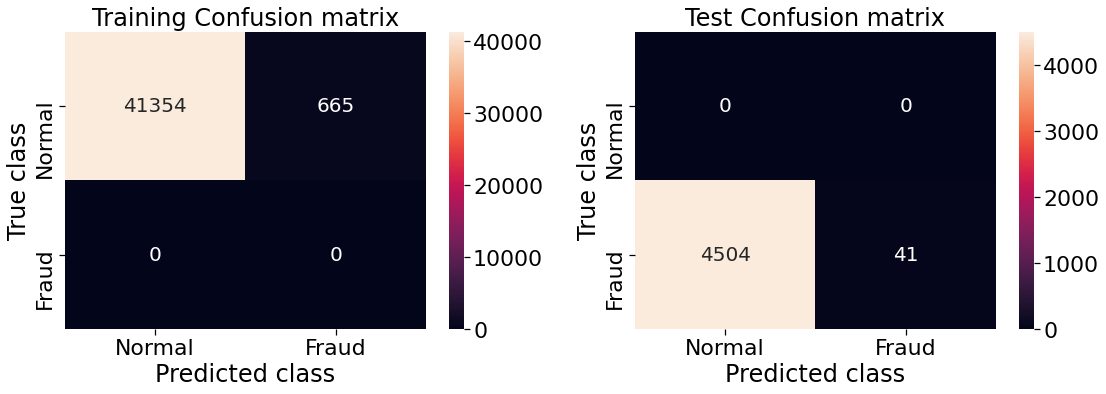

In [83]:
cnf_mtx_test = confusion_matrix(test_y, y_test_pred)
cnf_mtx_train = confusion_matrix(train_y, y_train_pred)
conf_matrix_normal(cnf_mtx_train, cnf_mtx_test)
plt.savefig('/home/lax/UWMSDS/AnomalyDetection/images/PCA_Mahanolobis dist_conf_matrix.jpg');

## 3. Kernel PCA

Dimensionality reduction algorithms reduce the dimensionality of data while attempting to minimize the reconstruction error. In other words, these algorithms try to capture the most salient information of the original features in such a way that they can reconstruct the original feature set from the reduced feature set as well as possible. However, these dimensionality reduction algorithms cannot capture all the information of the original features as they move to a lower dimensional space; therefore, there will be some error as these algorithms reconstruct the reduced feature set back to the original number of dimensions.

In the context of our credit card transactions dataset, the algorithms will have the largest reconstruction error on those transactions that are hardest to model—in other words, those that occur the least often and are the most anomalous. Since fraud is rare and presumably different than normal transactions, the fraudulent transactions should exhibit the largest reconstruction error. So let’s define the anomaly score as the reconstruction error. The reconstruction error for each transaction is the sum of the squared differences between the original feature matrix and the reconstructed matrix using the dimensionality reduction algorithm. We will scale the sum of the squared differences by the max-min range of the sum of the squared differences for the entire dataset, so that all the reconstruction errors are within a zero to one range.

The transactions that have the largest sum of squared differences will have an error close to one, while those that have the smallest sum of squared differences will have an error close to zero. The dimensionality reduction algorithm will effectively assign each transaction an anomaly score between zero and one. Zero is normal and one is anomalous (and most likely to be fraudulent).

In [84]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss



Evaluation metrics :
    Although we will not use the fraud labels to build the unsupervised fraud detection solutions, we will use the labels to evaluate the unsupervised solutions we develop. The labels will help us understand just how well these solutions are at catching known patterns of fraud.
    
The fraud labels and the evaluation metrics will help us assess just how good the unsupervised fraud detection systems are at catching known patterns of fraud—fraud that we have caught in the past and have labels for.

However, we will not be able to assess how good the unsupervised fraud detection systems are at catching unknown patterns of fraud. In other words, there may be fraud in the dataset that is incorrectly labeled as not fraud because the financial company never discovered it.

In [85]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.DataFrame(np.vstack((trueLabels, anomalyScores)).T)
    #print(preds)
    #preds = pd.concat([pd.DataFrame(trueLabels), anomalyScores], axis=0)

    preds.columns = ['trueLabel', 'anomalyScore']
   
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScore'])

    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

    plt.title('Precision-Recall curve: Average Precision = \
    {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.title('ROC: AUC = {0:0.2f}'.format(areaUnderROC), fontsize=20)
    plt.legend(loc="lower right")
    plt.tick_params(labelsize=20)
    plt.show()
    

    if returnPreds==True:
        return preds
    plt.savefig('/home/lax/UWMSDS/AnomalyDetection/images/KernalPCA_test_AUCROC.jpg');
    

Scatterplot function to display the separation of points the dimensionality reduction algorithm achieves in just the first two dimensions:

In [86]:
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName,fontsize=15)

Now let’s design a fraud detection solution using kernel PCA, which is a nonlinear form of PCA and is useful if the fraud transactions are not linearly separable from the nonfraud transactions.

We need to specify the number of components we would like to generate, the kernel (we will use the RBF kernel), and the gamma (which is set to 1/n_features by default, so 1/80 in our case). We also need to set the fit_inverse_transform to true to apply the built-in inverse_transform function provided by Scikit-Learn.

Finally, because kernel PCA is so expensive to train with, we will train on just the first two thousand samples in the transactions dataset. This is not ideal but it is necessary to perform experiments quickly.

We will use this training to transform the entire training set and generate the principal components. Then, we will use the inverse_transform function to recreate the original dimension from the principal components derived by kernel PCA:

X_train_subset  (29894, 17)


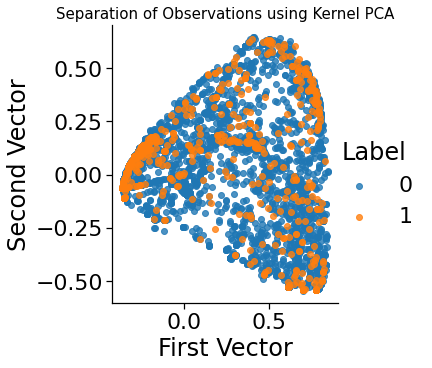

In [87]:
import random
n_components = 15
X_train_subset = X_train.loc[:,colNames]
#X_train_subset = X_train.iloc[:,selected_features]
kernel = 'rbf'
gamma = (1/X_train_subset.shape[1])
fit_inverse_transform = True
random_state = 2000
n_jobs = -1
y_train = pd.Series(y_train)
print("X_train_subset ",X_train_subset.shape)


kernelPCA = KernelPCA(n_components=n_components, kernel=kernel, \
                gamma=gamma, fit_inverse_transform= \
                fit_inverse_transform, n_jobs=n_jobs, \
                random_state=random_state)

kernelPCA.fit(X_train_subset.iloc[:5000])

X_train_kernelPCA = kernelPCA.transform(X_train_subset)

X_train_kernelPCA = pd.DataFrame(data=X_train_kernelPCA, \
                                 index=X_train_subset.index)

X_train_kernelPCA_inverse = kernelPCA.inverse_transform(X_train_kernelPCA)
X_train_kernelPCA_inverse = pd.DataFrame(data=X_train_kernelPCA_inverse, \
                                         index=X_train_subset.index)

scatterPlot(X_train_kernelPCA, y_train, "Kernel PCA")

Using kernel PCA, we calculated the reconstruction error for each of these 29894 transactions. If we sort these transactions by highest reconstruction error (also referred to as anomaly score) in descending order and extract the top 3470 transactions from the list, we can see that 288 of these transactions are fraudulent. This accounts for roughtly 8% of all fradulent transactions

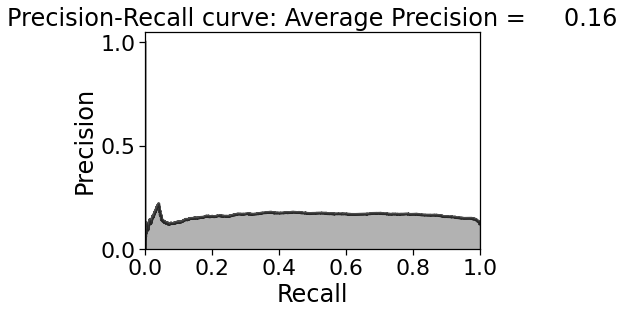

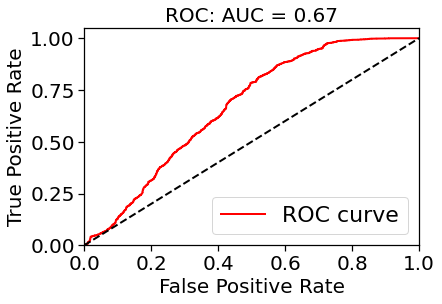

In [88]:
# View plot
train_anomalyScoresKernelPCA = anomalyScores(X_train_subset, X_train_kernelPCA_inverse)
preds_train = plotResults(y_train, train_anomalyScoresKernelPCA , True)

In [89]:
preds_train.reset_index(inplace=True,drop=True)

In [90]:
# Analyze results
preds_train.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 3462
predsTop = preds_train[:cutoff]
print("Train Evaluation Summary\n******************\n")
precision = np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/cutoff,2)
print("Precision: ",precision)
recall = np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2)
print("Recall: ",recall)
print("Fraud Caught out of 3462 Cases:", predsTop.trueLabel.sum())
f1_score = (2*precision*recall)/(precision+recall)
print("F1_illicit score: ",np.round(f1_score,4))

Train Evaluation Summary
******************

Precision:  0.15
Recall:  0.15
Fraud Caught out of 3462 Cases: 523.0
F1_illicit score:  0.15


We will use the PCA embedding that the PCA algorithm learned from the training set and use this to transform the test set. We will then use the Scikit-Learn inverse_transform function to recreate the original dimensions from the principal components matrix of the test set.

By comparing the original test set matrix with the newly reconstructed one, we can calculate the anomaly scores (as we’ve done many times before in this chapter):

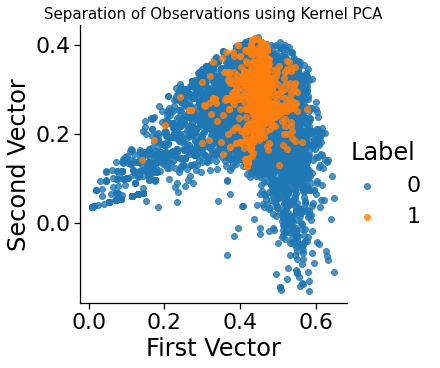

In [91]:
# PCA on Test Set
y_test = pd.Series(y_test)
X_test_subset = X_test.loc[:,colNames]
#[:,selected_features]
#X_test.loc[:,subset_cols]
X_test_kernelPCA = kernelPCA.transform(X_test_subset)
X_test_kernelPCA = pd.DataFrame(data=X_test_kernelPCA, index=X_test_subset.index)

X_test_kernelPCA_inverse = kernelPCA.inverse_transform(X_test_kernelPCA)
X_test_kernelPCA_inverse = pd.DataFrame(data=X_test_kernelPCA_inverse, \
                                  index=X_test_subset.index)
X_test_kernelPCA.reset_index(drop=True, inplace=True)

X_test_kernelPCA_inverse = kernelPCA.inverse_transform(X_test_kernelPCA)
X_test_kernelPCA_inverse = pd.DataFrame(data=X_test_kernelPCA_inverse, \
                                         index=X_test_subset.index)

scatterPlot(X_test_kernelPCA, y_test, "Kernel PCA")
plt.savefig('/home/lax/UWMSDS/AnomalyDetection/images/KernalPCA_test.jpg');

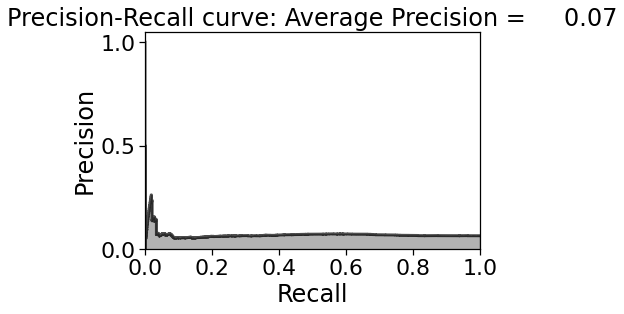

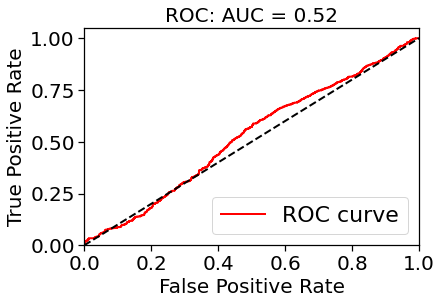

In [92]:
# View plot
test_anomalyScoresKernelPCA = anomalyScores(X_test_subset, X_test_kernelPCA_inverse)
preds_test = plotResults(y_test, test_anomalyScoresKernelPCA, True)

In [93]:
# Analyze results
preds_test.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 1083
predsTop = preds_test[:cutoff]
precision = np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/cutoff,2)
print("Precision: ",precision)
recall = np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y_test.sum(),2)
print("Recall: ",recall)
print("Fraud Caught out of 1083 Cases:", predsTop.trueLabel.sum())
f1_score = (2*precision*recall)/(precision+recall)
print("F1_illicit score: ",np.round(f1_score,4))

Precision:  0.08
Recall:  0.08
Fraud Caught out of 1083 Cases: 82.0
F1_illicit score:  0.08


In [94]:
X_test.shape

(16670, 165)

### 4. DBSCAN 

This is a clustering algorithm (an alternative to K-Means) that clusters points together and identifies any points not belonging to a cluster as outliers. It’s like K-means, except the number of clusters does not need to be specified in advance.

The method, step-by-step:

- Randomly select a point not already assigned to a cluster or designated as an outlier. Determine if it’s a core point by seeing if there are at least min_samples points around it within epsilon distance.

- Create a cluster of this core point and all points within epsilon distance of it (all directly reachable points).

- Find all points that are within epsilon distance of each point in the cluster and add them to the cluster. Find all points that are within epsilon distance of all newly added points and add these to the cluster. Rinse and repeat. (i.e. perform “neighborhood jumps” to find all density-reachable points and add them to the cluster).

Lingo underlying the above:

- Any point that has at least min_samples points within epsilon distance of it will form a cluster. This point is called a core point. The core point will itself count towards the min_samples requirement.

- Any point within epsilon distance of a core point, but does not have min_samples points that are within epsilon distance of itself is called a borderline point and does not form its own cluster.

- A border point that is within epsilon distance of multiple core points (multiple epsilon balls) will arbitrarily end up in just one of these resultant clusters.

- Any point that is randomly selected that is not found to be a core point or a borderline point is called a noise point or outlier and is not assigned to any cluster. Thus, it does not contain at least min_samples points that are within epsilon distance from it or is not within epsilon distance of a core point.

- The epsilon-neighborhood of point p is all points within epsilon distance of p, which are said to be directly reachable from p.

- A point contained in the neighborhood of a point directly reachable from p is not necessarily directly reachable from p, but is density-reachable.

- Any point that can be reached by jumping from neighborhood to neighborhood from the original core point is density-reachable.

Implementation Considerations:

1. You may need to standardize / scale / normalize your data first.

2. Be mindful of data type and the distance measure. I’ve read that the gower distance metric can be used for mixed data types. I’ve implemented Euclidean, here, which needs continuous variables, so I removed gender.

3. You will want to optimize epsilon and min_samples.


In [95]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

In [96]:
neighbors = NearestNeighbors(n_neighbors=40)
neighbors_fit = neighbors.fit(X_train_subset)
distances, indices = neighbors_fit.kneighbors(X_train_subset)

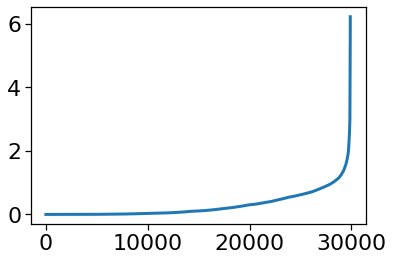

In [97]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [98]:
dbscan = DBSCAN(eps=1.80, min_samples=34)
dbscan.fit(X_train_subset)

DBSCAN(eps=1.8, min_samples=34)

In [99]:
knn = KNeighborsClassifier(n_neighbors=40)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

#y_train_pred = knn.predict(X_train_subset)
y_dist, y_pred_idx = knn.kneighbors(X_train_subset, n_neighbors=1)
y_train_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_train_pred[y_dist > 1.80] = -1
y_train_pred.ravel()
y_train_pred[y_train_pred >= 0] = 0
y_train_pred[y_train_pred == -1] = 1
y_train_pred= y_train_pred.reshape(-1)


#y_test_pred = knn.predict(X_test_subset)
y_dist, y_pred_idx = knn.kneighbors(X_test_subset, n_neighbors=1)
y_test_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_test_pred[y_dist > 1.80] = -1
y_test_pred.ravel()
y_test_pred[y_test_pred >= 0] = 0
y_test_pred[y_test_pred == -1] = 1
y_test_pred= y_test_pred.reshape(-1)

In [100]:
outliers_df_train = X_train_copy.loc[y_train_pred == -1]
print(len(outliers_df_train[outliers_df_train["class"] == "1"]))

outliers_df_test = X_test_copy.loc[y_test_pred == -1]
len(outliers_df_test[outliers_df_test["class"] == "1"])

0


0

In [101]:
print('Train Cluster Result:\n')
print(pd.value_counts(y_train_pred))

print('\n\nTest Cluster Result:\n')
print(pd.value_counts(y_test_pred))

Train Cluster Result:

0    28761
1     1133
dtype: int64


Test Cluster Result:

0    12648
1     4022
dtype: int64


In [102]:
print("Train Evaluation Summary\n******************")
print(evaluation_summary(y_train, y_train_pred, 'DBSCAN'))
print("Test Evaluation Summary\n******************")
print(evaluation_summary(y_test, y_test_pred, 'DBSCAN'))

Train Evaluation Summary
******************
For DBSCAN
Balanced Accuracy: 0.4937584
Macro Precision: 0.4824726
Macro Recall: 0.4937584
Macro F1: 0.4802977


Normal Accuracy: 0.8525122
Normal Precision: 0.082083
Normal Recall: 0.0268631
Normal F1: 0.0404788
Normal ROC-AUC: 0.4937584

              precision    recall  f1-score   support

           0       0.88      0.96      0.92     26432
           1       0.08      0.03      0.04      3462

    accuracy                           0.85     29894
   macro avg       0.48      0.49      0.48     29894
weighted avg       0.79      0.85      0.82     29894


None
Test Evaluation Summary
******************
For DBSCAN
Balanced Accuracy: 0.4608463
Macro Precision: 0.4870073
Macro Recall: 0.4608463
Macro F1: 0.4516952


Normal Accuracy: 0.7155969
Normal Precision: 0.0452511
Normal Recall: 0.1680517
Normal F1: 0.0713026
Normal ROC-AUC: 0.4608463

              precision    recall  f1-score   support

           0       0.93      0.75      0.83 

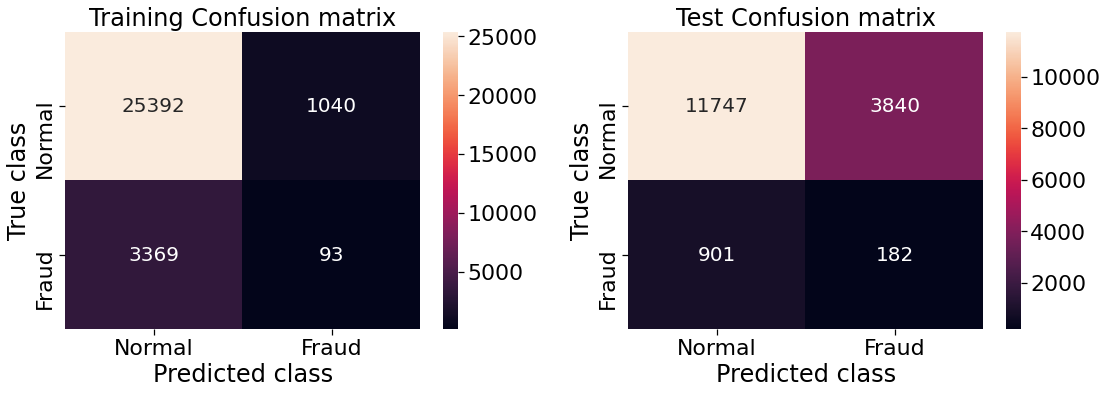

In [103]:
cnf_mtx_test = confusion_matrix(y_test, y_test_pred)
cnf_mtx_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_normal(cnf_mtx_train, cnf_mtx_test)

### Isolation Forest

REF: https://medium.com/sfu-cspmp/alone-in-the-woods-anomaly-detection-using-isolation-forests-c244492dfdd9

Isolation forests are built on the basis of decision trees, where points that can be isolated from other data are more likely to be anomalies.

- Isolation forests use random partitioning which makes it easier to discover anomalies.
- Isolation forests only require a few conditions to separate anomalies from normal observations when compared to -other methods which use basic distance and density measures.
- Isolation forests have low linear time complexity and a small memory requirement, eliminating major computational cost of distance calculation in all distance and density-based methods.
- Isolation forests work nicely in a multi-dimensional feature space


Like other anomaly detection methods, isolation forests may result in swamping and/or masking. Swamping is the phenomenon in which normal values present in the data set can be considered as anomalies. Masking is the opposite where anomalous points are classified as normal. Both of these minor setbacks can be overcome by sub-sampling. Sub-sampling isolates the large chunks of training sample and works well when the sampling size is small where it can determine with greater accuracy if a point is normal or an anomaly 


How Does it Work?
- The algorithm builds an ensemble of isolation trees (iTrees) for the given data set and anomalies are those instances which have short average path lengths on the iTrees. 
- An iTree is a proper binary tree, where each node in the tree has zero or two daughter nodes
- A normal (inlier) point which requires more partitions to be isolated. An anomaly which requires fewer partitions to be isolated. The number of partitions required to isolate a point is equivalent to the path length from the root node to a terminating node, or if provided, reaches the maximum allowed height. Shorter paths indicate anomalies, while longer paths indicate normal points


- Decision boundaries in traditional isolation forests are one-dimensional (either vertical or horizontal), parallel to the axes. There are regions that contain many branch cuts and only a single or few observations, which may mask some anomalies as normal
- Extended isolation forests mitigate this issue by using hyperplanes for splitting the data with random slopes. Hyperplanes have dimensions one less than the dimension of the data. 
- Variance between scores tends to be lower with extended isolation forests compared to traditional ones, making it easier to detect anomalies 

## Iterative Modelling

#### Get training sample

In [104]:
def get_training_sample(n):
    normal_sample = original_train_normal_df.sample(n)
    final_sample = pd.concat([normal_sample, original_train_fraud_df])
    final_sample = shuffle(final_sample)

    return final_sample.iloc[:,:-1].values, final_sample.iloc[:,-1].values

#### Get test sample

In [105]:
def get_test_sample(n):
    normal_sample = original_test_normal_df.sample(n)
    final_sample = pd.concat([normal_sample, original_test_fraud_df])
    final_sample = shuffle(final_sample)
    return final_sample.iloc[:,:-1].values, final_sample.iloc[:,-1].values

#### Oversample Training Data

In [106]:
#pip install imbalanced-learn

In [107]:
from imblearn.over_sampling import SMOTE

def oversample_minority_class(X, y, fraction):
    SM = SMOTE(fraction, n_jobs=-1)
    return SM.fit_resample(X, y)

#### Evaluation Metrics

In [108]:
def evaluate(actual, predicted, probability, time_complexity):
    eval_metric = {}
    eval_metric['time'] = time_complexity
    eval_metric['conf_matrix'] = confusion_matrix(actual, predicted)
    
    #eval_metric['balanced_accuracy'] = round(balanced_accuracy_score(actual, predicted),7)
    eval_metric['accuracy'] = round(accuracy_score(actual, predicted),7)
    
    #eval_metric['macro_precision'] = round(precision_score(actual, predicted, average="macro"),7)
    #eval_metric['macro_recall'] = round(recall_score(actual,predicted, average="macro"),7)
    #eval_metric['macro_f1'] = round(f1_score(actual,predicted, average="macro"),7)
    #eval_metric['macro_roc'] = round(roc_auc_score(actual, probability, average="macro"),7)

    
    eval_metric['precision'] = round(precision_score(actual, predicted),7)
    eval_metric['recall'] = round(recall_score(actual,predicted),7)
    eval_metric['f1'] = round(metrics.f1_score(actual,predicted),7)
    eval_metric['roc'] = round(roc_auc_score(actual, probability),7)

    false_pos_rate, true_pos_rate, thresholds = roc_curve(actual, probability)
    eval_metric['false_pos_rate'] = false_pos_rate
    eval_metric['true_pos_rate'] = true_pos_rate
    eval_metric['thresholds'] = thresholds
    
    precision_rt, recall_rt, threshold_rt = precision_recall_curve(actual, probability)
    eval_metric['precision_rt'] = precision_rt
    eval_metric['recall_rt'] = recall_rt
    eval_metric['threshold_rt'] = threshold_rt
    return eval_metric

#### Fit Model

In [109]:
def fit_model(X,clf_type,):
    if clf_type=='IForest':
        clf = IForest(n_estimators=40, contamination=outliers_fraction, random_state=random_state, n_jobs=-1)
        clf.fit(X)
    elif clf_type=='OneClassSVM':
        clf = OCSVM(kernel='rbf', nu=outliers_fraction, gamma=0.0000001) 
        clf.fit(X)
    elif clf_type=='EIForest':
        clf = iso.iForest(X, 
                  ntrees = 40, 
                  sample_size = training_sample_size, 
                  ExtensionLevel = X.shape[1] - 1)
    elif clf_type=='DBSCAN':
        clf = DBSCAN(eps=1.80, min_samples=X.shape[1]*2)
        clf.fit(X)
    elif clf_type=='LOF':
        clf=LocalOutlierFactor(contamination=outliers_fraction,novelty=False )
    return clf

#### Iterative Modeling

In [110]:
def iterative_modeling(training_sample_size,iterations,clf_type='EIForest'):
    print()
    training_evaluations = {}
    test_evaluations = {}
    model={}
    f1_step[clf_type] = {}
    logs[clf_type] = {}
    out[clf_type] = {}
    n_components=15

    for i in range(0, iterations):
        
        sample_Xtrain, sample_ytrain = get_training_sample(training_sample_size)
        X_train_sub, y_train_sub = oversample_minority_class(sample_Xtrain, sample_ytrain, oversampling_fraction)
        print("Iteration "+ str(i+1) + " in progress...")

        #Modeling
        start = time.time()
        clf = fit_model(X_train_sub,clf_type)
        
        if clf_type == "EIForest":
            y_train_scores = clf.compute_paths(X_in = X_train_sub)
            end = time.time()
            y_train_scores_sorted = np.argsort(y_train_scores)
            indices_with_preds = y_train_scores_sorted[-int(np.ceil(outliers_fraction * X_train_sub.shape[0])):]
            y_train_pred = np.zeros_like(y_train_sub)
            y_train_pred[indices_with_preds] = 1
            training_time = round(end - start, 4)
            model[i+1] = clf
            training_evaluations[i+1] = evaluate(y_train_sub, y_train_pred, y_train_scores, training_time)
            
            test_start = time.time()
            y_test_scores = clf.compute_paths(X_in = X_test_subset.values)
            y_test_scores_sorted = np.argsort(y_test_scores)
            indices_with_preds = y_test_scores_sorted[-int(np.ceil(outliers_fraction * X_test_subset.shape[0])):]
            y_test_pred = np.zeros_like(y_test)
            y_test_pred[indices_with_preds] = 1
            training_time = round(end - start, 4)
            test_end = time.time()
            testing_time = round(test_end - test_start, 4)
            test_evaluations[i+1] = evaluate(y_test, y_test_pred, y_test_scores, testing_time) 
        elif clf_type=="LOF":
            y_train_pred = clf.fit_predict(X_train_sub)
            end = time.time()
            y_train_pred[y_train_pred == 1] = 0
            y_train_pred[y_train_pred == -1] = 1
            y_train_scores= clf.negative_outlier_factor_
            training_time = round(end - start, 4)
            model[i+1] = clf
            training_evaluations[i+1] = evaluate(y_train_sub, y_train_pred, y_train_scores, training_time)
            
            test_start = time.time()
            y_test_pred = clf.fit_predict(X_test_subset)
            y_test_pred[y_test_pred == 1] = 0
            y_test_pred[y_test_pred == -1] = 1
            y_test_scores= clf.negative_outlier_factor_
            test_end = time.time()
            testing_time = round(test_end - test_start, 4)
            test_evaluations[i+1] = evaluate(y_test, y_test_pred, y_test_scores, testing_time)
        elif clf_type=="DBSCAN":
            knn = KNeighborsClassifier(n_neighbors=40)
            knn.fit(clf.components_, clf.labels_[clf.core_sample_indices_])

            y_dist, y_pred_idx = knn.kneighbors(X_train_sub, n_neighbors=1)
            y_train_scores=y_dist            
            y_train_pred = clf.labels_[clf.core_sample_indices_][y_pred_idx]
            y_train_pred[y_dist > 1.80] = -1
            y_train_pred.ravel()
            y_train_pred[y_train_pred >= 0] = 0
            y_train_pred[y_train_pred == -1] = 1
            y_train_pred= y_train_pred.reshape(-1)
            end = time.time()
            training_time = round(end - start, 4)
            model[i+1] = clf
            training_evaluations[i+1] = evaluate(y_train_sub, y_train_pred, y_train_scores, training_time)
            
            test_start = time.time()
            y_dist, y_pred_idx = knn.kneighbors(X_test_subset, n_neighbors=1)
            y_test_scores=y_dist            
            y_test_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
            y_test_pred[y_dist > 1.80] = -1
            y_test_pred.ravel()
            y_test_pred[y_test_pred >= 0] = 0
            y_test_pred[y_test_pred == -1] = 1
            y_test_pred= y_test_pred.reshape(-1)
            test_end = time.time()
            testing_time = round(test_end - test_start, 4)
            test_evaluations[i+1] = evaluate(y_test, y_test_pred, y_test_scores, testing_time)
        else:
        # get the prediction labels and outlier scores of the training data
            y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
            y_train_scores = clf.decision_scores_  # raw outlier scores
            end = time.time()

            training_time = round(end - start, 4)
            model[i+1] = clf
            training_evaluations[i+1] = evaluate(y_train_sub, y_train_pred, y_train_scores, training_time)
            

            #     print("Iteration "+ str(i+1)+ " Trained")
            test_start = time.time()
            y_test_pred = clf.predict(X_test_subset)
            y_test_scores = clf.decision_function(X_test_subset)
            test_end = time.time()
            testing_time = round(test_end - test_start, 4)
            test_evaluations[i+1] = evaluate(y_test, y_test_pred, y_test_scores, testing_time)

        logs[clf_type][i]= metrics.f1_score(y_test, y_test_pred, pos_label=1)
        f1_step[clf_type][i]= compute_f1_score_per_step(y_test,y_test_pred)
        res[clf_type] = list(logs[clf_type].values())
        
    for log in f1_step[clf_type].values():
        for k,v in log.items():
            if k in out[clf_type]:
                out[clf_type][k].append(v)
            else:
                out[clf_type][k] = []

    for k,v in out[clf_type].items():
        out[clf_type][k] = np.mean(out[clf_type][k])
    
    print("Iterative Modeling Completed for "+clf_type+"!")
    return training_evaluations, test_evaluations,logs,f1_step,res,out

#### Tabular Evaluation

In [111]:
def evaluate_metrics(training_evaluations, test_evaluations):    
    training_eval_df = pd.DataFrame(columns=['Iteration','Accuracy','Precision', 'Recall', 'F1', 'ROC', 'Time'])
    #'Balanced-Accuracy','Macro-Precision','Macro-Recall','Macro-F1','Macro-ROC'
    test_eval_df = pd.DataFrame(columns=['Iteration','Accuracy', 'Precision', 'Recall', 'F1', 'ROC', 'Time'])
    for it in list(training_evaluations.keys()):
        training_eval_df = training_eval_df.append({'Iteration' : str(it),
                                 'Accuracy' : training_evaluations[it]['accuracy'],
                                # 'Balanced-Accuracy' : training_evaluations[it]['balanced_accuracy'],
                                # 'Macro-Precision' : training_evaluations[it]['macro_precision'],
                                # 'Macro-Recall' : training_evaluations[it]['macro_recall'],
                                # 'Macro-F1' : training_evaluations[it]['macro_f1'],
                                # 'Macro-ROC' : training_evaluations[it]['macro_roc'],
                                 'Precision' : training_evaluations[it]['precision'],
                                 'Recall' : training_evaluations[it]['recall'],
                                 'F1' : training_evaluations[it]['f1'],
                                 'ROC' : training_evaluations[it]['roc'],
                                 'Time' : training_evaluations[it]['time']                                              
                                }, ignore_index=True)

    for it in list(test_evaluations.keys()):
        test_eval_df = test_eval_df.append({'Iteration' : str(it),
                                 'Accuracy' : test_evaluations[it]['accuracy'],
                                # 'Balanced-Accuracy' : test_evaluations[it]['balanced_accuracy'],
                                # 'Macro-Precision' : test_evaluations[it]['macro_precision'],
                                # 'Macro-Recall' : test_evaluations[it]['macro_recall'],
                                # 'Macro-F1' : test_evaluations[it]['macro_f1'],
                                # 'Macro-ROC' : test_evaluations[it]['macro_roc'],
                                 'Precision' : test_evaluations[it]['precision'],
                                 'Recall' : test_evaluations[it]['recall'],
                                 'F1' : test_evaluations[it]['f1'],
                                 'ROC' : test_evaluations[it]['roc'],
                                 'Time' : test_evaluations[it]['time']                                              
                                }, ignore_index=True)
    return training_eval_df, test_eval_df

In [112]:
"""
logs={}
res={}
f1_step={}
out={}
"""

X_train_subset = X_train.loc[:,colNames]
X_test_subset = X_test.loc[:,colNames]

original_train_df = X_train_subset.copy()
original_train_df['fraud'] = y_train
original_train_df.reset_index(drop=True)
original_train_normal_df = original_train_df[original_train_df.fraud == 0]
original_train_fraud_df = original_train_df[original_train_df.fraud == 1]


original_test_df = X_test_subset.copy()
original_test_df['fraud'] = y_test
original_test_df.reset_index(drop=True)
original_test_normal_df = original_test_df[original_test_df.fraud == 0]
original_test_fraud_df = original_test_df[original_test_df.fraud == 1]

iterations = 5
training_sample_size = int(len(y_train) / iterations)
oversampling_fraction = 0.9
outliers_fraction = len(original_train_fraud_df)/len(original_train_normal_df)

print('Training Parameters:\n====================\n')
print('Iterations: '+ str(iterations))
print('Training Sample Size: '+ str(training_sample_size))
print('Oversampling Fraction: '+ str(oversampling_fraction))
print('Outliers Fraction: '+ str(outliers_fraction))

training_eval_df = {}
test_eval_df = {}
training_eval_df={}
test_eval_df={}

clf_type='LOF'
training_evaluations, test_evaluations,logs,f1_step,res,out = iterative_modeling(training_sample_size,iterations,clf_type)
training_eval_df[clf_type], test_eval_df[clf_type] = evaluate_metrics(training_evaluations, test_evaluations)
print("Avg F1 score train "+clf_type+" : ",np.mean(training_eval_df[clf_type]['F1']))
print(training_eval_df[clf_type].sort_values('F1', ascending=False))
print()
print("Avg F1 score test "+clf_type+" : ",np.mean(test_eval_df[clf_type]['F1']))
print("Avg precision score test "+clf_type+" : ",np.mean(test_eval_df[clf_type]['Precision']))
print("Avg recall score test "+clf_type+" : ",np.mean(test_eval_df[clf_type]['Recall']))
print("Avg accuarcy score test "+clf_type+" : ",np.mean(test_eval_df[clf_type]['Accuracy']))
print("Avg roc score test "+clf_type+" : ",np.mean(test_eval_df[clf_type]['ROC']))
print(test_eval_df[clf_type].sort_values('F1', ascending=False))


clf_type='IForest'
training_evaluations, test_evaluations,logs,f1_step,res,out = iterative_modeling(training_sample_size,iterations,clf_type)
training_eval_df[clf_type], test_eval_df[clf_type] = evaluate_metrics(training_evaluations, test_evaluations)
print("Avg F1 score train "+clf_type+" : ",np.mean(training_eval_df[clf_type]['F1']))
print(training_eval_df[clf_type].sort_values('F1', ascending=False))
print()
print("Avg F1 score test "+clf_type+" : ",np.mean(test_eval_df[clf_type]['F1']))
print("Avg precision score test "+clf_type+" : ",np.mean(test_eval_df[clf_type]['Precision']))
print("Avg recall score test "+clf_type+" : ",np.mean(test_eval_df[clf_type]['Recall']))
print("Avg accuarcy score test "+clf_type+" : ",np.mean(test_eval_df[clf_type]['Accuracy']))
print("Avg roc score test "+clf_type+" : ",np.mean(test_eval_df[clf_type]['ROC']))
print(test_eval_df[clf_type].sort_values('F1', ascending=False))


clf_type='EIForest'
training_evaluations, test_evaluations,logs,f1_step,res,out = iterative_modeling(training_sample_size,iterations,clf_type)
training_eval_df[clf_type], test_eval_df[clf_type] = evaluate_metrics(training_evaluations, test_evaluations)
print("Avg F1 score train "+clf_type+" : ",np.mean(training_eval_df[clf_type]['F1']))
print(training_eval_df[clf_type].sort_values('F1', ascending=False))
print()
print("Avg F1 score test "+clf_type+" : ",np.mean(test_eval_df[clf_type]['F1']))
print("Avg precision score test "+clf_type+" : ",np.mean(test_eval_df[clf_type]['Precision']))
print("Avg recall score test "+clf_type+" : ",np.mean(test_eval_df[clf_type]['Recall']))
print("Avg accuarcy score test "+clf_type+" : ",np.mean(test_eval_df[clf_type]['Accuracy']))
print("Avg roc score test "+clf_type+" : ",np.mean(test_eval_df[clf_type]['ROC']))
print(test_eval_df[clf_type].sort_values('F1', ascending=False))

clf_type='OneClassSVM'
training_evaluations, test_evaluations,logs,f1_step,res,out = iterative_modeling(training_sample_size,iterations,clf_type)
training_eval_df[clf_type], test_eval_df[clf_type] = evaluate_metrics(training_evaluations, test_evaluations)
print("Avg F1 score train "+clf_type+" : ",np.mean(training_eval_df[clf_type]['F1']))
print(training_eval_df[clf_type].sort_values('F1', ascending=False))
print()
print("Avg F1 score test "+clf_type+" : ",np.mean(test_eval_df[clf_type]['F1']))
print("Avg precision score test "+clf_type+" : ",np.mean(test_eval_df[clf_type]['Precision']))
print("Avg recall score test "+clf_type+" : ",np.mean(test_eval_df[clf_type]['Recall']))
print("Avg accuarcy score test "+clf_type+" : ",np.mean(test_eval_df[clf_type]['Accuracy']))
print("Avg roc score test "+clf_type+" : ",np.mean(test_eval_df[clf_type]['ROC']))
print(test_eval_df[clf_type].sort_values('F1', ascending=False))


clf_type='DBSCAN'
training_evaluations, test_evaluations,logs,f1_step,res,out = iterative_modeling(training_sample_size,iterations,clf_type)
training_eval_df[clf_type], test_eval_df[clf_type] = evaluate_metrics(training_evaluations, test_evaluations)
print("Avg F1 score train "+clf_type+" : ",np.mean(training_eval_df[clf_type]['F1']))
print(training_eval_df[clf_type].sort_values('F1', ascending=False))
print()
print("Avg F1 score test "+clf_type+" : ",np.mean(test_eval_df[clf_type]['F1']))
print("Avg precision score test "+clf_type+" : ",np.mean(test_eval_df[clf_type]['Precision']))
print("Avg recall score test "+clf_type+" : ",np.mean(test_eval_df[clf_type]['Recall']))
print("Avg accuarcy score test "+clf_type+" : ",np.mean(test_eval_df[clf_type]['Accuracy']))
print("Avg roc score test "+clf_type+" : ",np.mean(test_eval_df[clf_type]['ROC']))
print(test_eval_df[clf_type].sort_values('F1', ascending=False))


Training Parameters:

Iterations: 5
Training Sample Size: 5978
Oversampling Fraction: 0.9
Outliers Fraction: 0.12714047582967117

Iteration 1 in progress...
Iteration 2 in progress...
Iteration 3 in progress...
Iteration 4 in progress...
Iteration 5 in progress...
Iterative Modeling Completed for LOF!
Avg F1 score train LOF :  0.1443142
  Iteration  Accuracy  Precision    Recall        F1       ROC    Time
3         4  0.487586   0.347645  0.093309  0.147128  0.602949  2.2085
0         1  0.486705   0.344183  0.092379  0.145662  0.604606  2.1055
2         3  0.485649   0.340028  0.091264  0.143904  0.607179  2.1522
1         2  0.485297   0.338643  0.090892  0.143318  0.606619  2.2473
4         5  0.484240   0.334487  0.089777  0.141559  0.606320  2.0775

Avg F1 score test LOF :  0.0605682
Avg precision score test LOF :  0.0457547
Avg recall score test LOF :  0.089566
Avg accuarcy score test LOF :  0.8194961
Avg roc score test LOF :  0.5002758
  Iteration  Accuracy  Precision    Recall

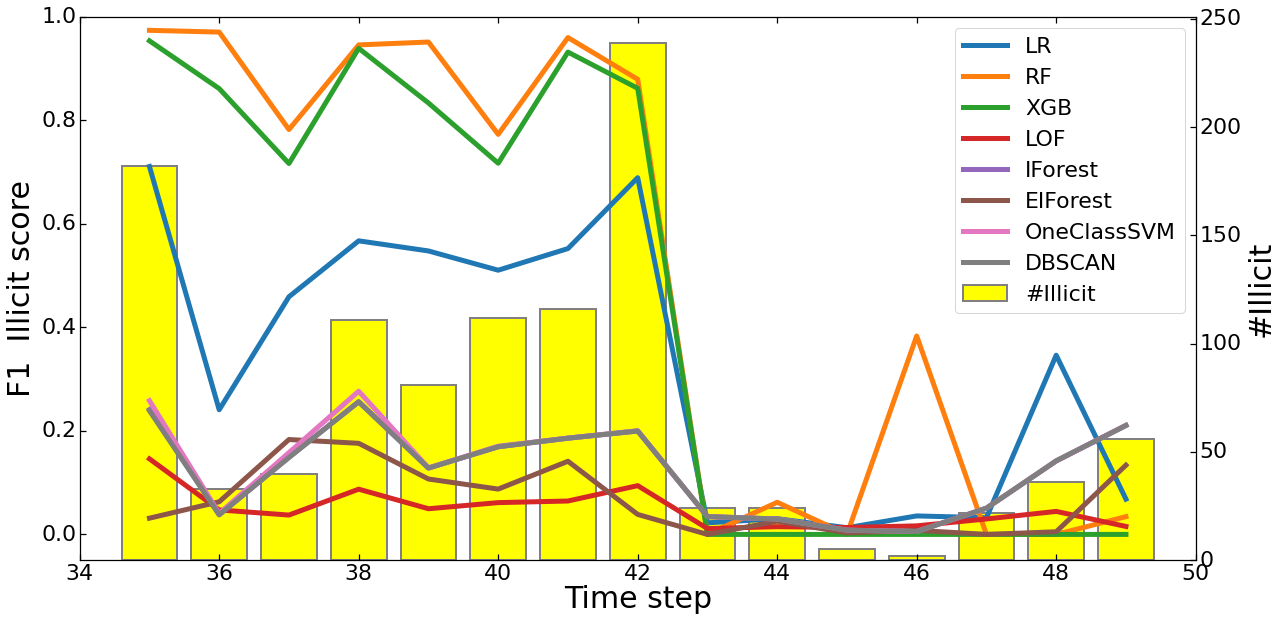

In [113]:
logs_count = compute_count()
logs_all = list(out.values())
logs_score = [list(log.values()) for log in logs_all]
count = list(logs_count.values())
steps = range(35,50)
plot_f1_score_step()

In [114]:
model_avg_unsupervised_f1_score = {'Local Outlier Factor': np.mean(res['LOF']), 'Isolation Forest': np.mean(res['IForest']),
                     'Extended Isolation Forest': np.mean(res['EIForest']),'One Class SVM': np.mean(res['OneClassSVM']),
                                   'DBSCAN': np.mean(res['DBSCAN'])}
print(model_avg_unsupervised_f1_score)

{'Local Outlier Factor': 0.06056821729628473, 'Isolation Forest': 0.12212174977909399, 'Extended Isolation Forest': 0.0678114267873868, 'One Class SVM': 0.12392434916647763, 'DBSCAN': 0.12200754802005295}


In [115]:
model_avg_unsupervised_f1_score

{'Local Outlier Factor': 0.06056821729628473,
 'Isolation Forest': 0.12212174977909399,
 'Extended Isolation Forest': 0.0678114267873868,
 'One Class SVM': 0.12392434916647763,
 'DBSCAN': 0.12200754802005295}